In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data, plot_latent_states 
from tools.ae_v1 import Autoencoder
from tools.hyper_param import trainAE_and_return_testError

In [8]:
strategy = None

In [9]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-17 23:34:35.407662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 23:34:35.408349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 23:34:35.456172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 23:34:35.456421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 23:34:35.456610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *


# loading data directory
data_dir_idx = '000'

# making ae save directory
dir_name_ae_nsb = os.getcwd() + dir_sep + 'saved_ae_ContractiveLmda_SearchBayes'
if not os.path.isdir(dir_name_ae_nsb):
    os.makedirs(dir_name_ae_nsb)

counter = 0
while True:
    dir_check = 'nsb_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_ae_nsb + dir_sep + dir_check):
        counter += 1
    else:
        break
        
dir_name_ae_nsb = dir_name_ae_nsb + dir_sep + dir_check
os.makedirs(dir_name_ae_nsb)
dir_name_aensb_plots = dir_name_ae_nsb+dir_sep+'plots'
os.makedirs(dir_name_aensb_plots)

print('dir_name_ae_nsb:', dir_name_ae_nsb)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae_nsb: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 500026]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# dealing with normalizing the data before feeding into autoencoder

# normalize data before feeding into autoencoder?
normalizeforae_flag = True
normalization_type = 'stddev' # could be 'stddev' or 'minmax'
stddev_multiplier = 3
stddev_multiplier_pm = 1
num_params = params_mat.shape[1]

ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if ae_data_with_params == False:
    stddev_multiplier_pm = None
if normalizeforae_flag == False:
    stddev_multiplier = None

if ae_data_with_params == True and alldata_withparams_flag == False:
    new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
    new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
    del(all_data)
    all_data = new_all_data
    prev_idx = 0
    for i in range(boundary_idx_arr.shape[0]):
        all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
        prev_idx = boundary_idx_arr[i]

normalization_constant_arr_aedata = None
if normalizeforae_flag == True:
    normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
    if normalization_type == 'stddev':
        sample_mean = np.mean(all_data, axis=0)
        sample_std = np.std(all_data, axis=0)
        normalization_constant_arr_aedata[0, :] = sample_mean
        normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
        if ae_data_with_params == True:
            normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
        zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
        if len(zero_idx) > 0:
            normalization_constant_arr_aedata[1, zero_idx] = 1.0
    elif normalization_type == 'minmax':
        for i in range(all_data.shape[1]):
            sample_min = np.min(all_data[:, i])
            sample_max = np.max(all_data[:, i])
            if sample_max - sample_min == 0:
                sample_min = sample_min - 0.5
                sample_max = sample_min + 1
            normalization_constant_arr_aedata[0, i] = sample_min
            normalization_constant_arr_aedata[1, i] = sample_max - sample_min
    # if ae_data_with_params == True:
    #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
    #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
    for i in range(all_data.shape[1]):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

# saving sim data
ae_data = {
    'data_dir_idx':data_dir_idx,
    'normalizeforae_flag':normalizeforae_flag,
    'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
    'normalization_type':normalization_type,
    'stddev_multiplier':stddev_multiplier,
    'stddev_multiplier_pm':stddev_multiplier_pm,
    'ae_data_with_params':ae_data_with_params,
    'module':Autoencoder.__module__,
}
with open(dir_name_ae_nsb+dir_sep+'ae_data.txt', 'w') as f:
    f.write(str(ae_data))
np.savez(
    dir_name_ae_nsb+dir_sep+'normalization_data',
    normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
)
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [21]:
normalization_constant_arr_aedata

array([[1.04895428e-01, 1.00677975e-01, 1.01455748e-01, 1.07038975e-01,
        1.15524963e-01, 1.24498643e-01, 1.32090986e-01, 1.37528211e-01,
        1.41156599e-01, 1.44102126e-01, 1.47524297e-01, 1.51665181e-01,
        1.54968590e-01, 1.54004678e-01, 1.45411506e-01, 1.28925756e-01,
        1.08675964e-01, 9.11559835e-02, 8.14666823e-02, 8.09827968e-02,
        8.77058581e-02, 9.81689095e-02, 1.08952150e-01, 1.17303252e-01,
        1.21563986e-01, 1.21806026e-01, 1.19666912e-01, 1.17023595e-01,
        1.14840910e-01, 1.13341480e-01, 1.12681627e-01, 1.12990953e-01,
        1.14061654e-01, 1.15491308e-01, 1.17183998e-01, 1.19535834e-01,
        1.23133965e-01, 1.28426880e-01, 1.35574624e-01, 1.44235477e-01,
        1.52901426e-01, 1.58540055e-01, 1.57794520e-01, 1.49408311e-01,
        1.35650888e-01, 1.21296138e-01, 1.11013673e-01, 1.07349895e-01,
        1.10332102e-01, 1.18103951e-01, 1.27738327e-01, 1.36243924e-01,
        1.41599804e-01, 1.43402293e-01, 1.42630473e-01, 1.407220

# Autoencoder

In [22]:
# setting up training params
learning_rate_list = [1e-3, 1e-4]#, 1e-5]
epochs = 200
patience = 10  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 2**6
dt_ae = 0.2

# stddev = fRMS*timeMeanofSpaceRMS
# contractive_lmda = 0.0
fRMS = 1.07498237e-03
lambda_reg = 1.00542493e-07
use_weights_post_dense = True
dropout_rate = 0.0


# saving training params
training_specific_params = {
    'learning_rate_list':learning_rate_list,
    'epochs':epochs,
    'patience':patience,
    'min_delta':min_delta,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'contractive_lmda':contractive_lmda,
    'dropout_rate':dropout_rate,
    'dt_ae':dt_ae,
    'fRMS':fRMS,
    'lambda_reg':lambda_reg,
}

with open(dir_name_ae_nsb+dir_sep+'training_specific_params.txt', 'w') as f:
    f.write(str(training_specific_params))

In [23]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = (num_elems_pre_indexing+skip_factor-1)//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [24]:
boundary_idx_arr

array([250013])

In [25]:
all_data.shape

(250013, 64)

In [26]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [27]:
#

In [28]:
# Initialize network
latent_space_dim = 16
enc_layers = [128, 96, 64, 48, 32, 24, 16, 8, 4]
# enc_layers = [192, 96, 48, 24, 12, 6, 3]
# enc_layers = [96, 48, 24, 12, 6, 3]
# enc_layers = [128, 64, 32, 16, 8, 4]
# enc_layers = []
# enc_layers = [32, 16, 8, 4]
for i in range(len(enc_layers)):
    if latent_space_dim < enc_layers[-i-1]:
        enc_layers = enc_layers[0:-i]
        break
    if i == len(enc_layers)-1:
        enc_layers = []
dec_layers = enc_layers[::-1]
# enc_layers = [16, 8, 8]
# dec_layers = [8, 8, 16]

enc_layer_act_func = 'elu' #'modified_relu_2'
enc_final_layer_act_func = 'tanh'
dec_layer_act_func = 'elu' #'modified_relu_2'
dec_final_layer_act_func = 'tanh'
reg_name = 'L2'

In [29]:
#

In [30]:
def optim_func(
        x, # [contractive_lmda]
        time_stddev=time_stddev,
        Autoencoder=Autoencoder,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        readAndReturnLossHistories=readAndReturnLossHistories,
        plot_reconstructed_data=plot_reconstructed_data,
        plot_latent_states=plot_latent_states,
        dir_name_ae=dir_name_ae_nsb,
        training_data=training_data,
        testing_data=testing_data,
        val_data=val_data,
        boundary_idx_arr=boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        fRMS=fRMS,
        lambda_reg=lambda_reg,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name,
    ):
    
    test_mse = trainAE_and_return_testError(
        [fRMS, lambda_reg, x[0]], # [fRMS, lambda_reg]
        time_stddev,
        og_vars,
        Autoencoder,
        mytimecallback,
        SaveLosses,
        plot_losses,
        readAndReturnLossHistories,
        plot_reconstructed_data,
        plot_latent_states,
        dir_name_ae,
        training_data,
        testing_data,
        val_data,
        boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=None,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name
    )
    
    return test_mse

In [31]:
contractive_lmda_bounds = (1e-3, 5., "log-uniform")
acq_func = "EI"
n_initial_points = 5
n_calls = n_initial_points + 25


optim_dict = {
    'contractive_lmda_bounds':contractive_lmda_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_ae_nsb + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [32]:
res = gp_minimize(
    optim_func,
    [contractive_lmda_bounds,],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0493 - mse: 0.0492 - NMSE: 0.4425 - real_MSE: 0.0492 - params_MSE: nan - ls_jacobian_norm: 0.0222 - tot_time: 0h 0m 24.5s

Epoch 1: val_mse improved from inf to 0.04166, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 24s 7ms/step - loss: 0.0493 - mse: 0.0492 - NMSE: 0.4425 - real_MSE: 0.0492 - params_MSE: nan - ls_jacobian_norm: 0.0222 - val_loss: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0142 - mse: 0.0140 - NMSE: 0.1262 - real_MSE: 0.0140 - params_MSE: nan - ls_jacobian_norm: 0.0031 - val_loss: 0.0141 - val_mse: 0.0139 - val_NMSE: 0.1254 - val_real_MSE: 0.0139 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0136 - mse: 0.0135 - NMSE: 0.1211 - real_MSE: 0.0135 - params_MSE: nan - ls_jacobian_norm: 0.0030 - tot_time: 0h 4m 3.9s

Epoch 11: val_mse did not improve from 0.01393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0136 - mse: 0.0135 - NMSE: 0.1211 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0108 - mse: 0.0107 - NMSE: 0.0960 - real_MSE: 0.0107 - params_MSE: nan - ls_jacobian_norm: 0.0025 - val_loss: 0.0110 - val_mse: 0.0108 - val_NMSE: 0.0976 - val_real_MSE: 0.0108 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0107 - mse: 0.0105 - NMSE: 0.0944 - real_MSE: 0.0105 - params_MSE: nan - ls_jacobian_norm: 0.0024 - tot_time: 0h 8m 6.0s

Epoch 22: val_mse improved from 0.01084 to 0.01002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested

Epoch 32: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0087 - mse: 0.0086 - NMSE: 0.0770 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 0.0019 - tot_time: 0h 12m 10.7s

Epoch 1: val_mse improved from 0.01002 to 0.00922, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0087 - mse: 0.0086 - NMSE: 0.0770 - real_MSE: 0.0086 - params_MSE: nan - ls_jacob

3125/3126 [============================>.] - ETA: 0s - loss: 0.0085 - mse: 0.0083 - NMSE: 0.0744 - real_MSE: 0.0083 - params_MSE: nan - ls_jacobian_norm: 7.4271e-04 - tot_time: 0h 15m 50.0s

Epoch 11: val_mse did not improve from 0.00898
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0085 - mse: 0.0083 - NMSE: 0.0744 - real_MSE: 0.0083 - params_MSE: nan - ls_jacobian_norm: 7.4269e-04 - val_loss: 0.0094 - val_mse: 0.0092 - val_NMSE: 0.0830 - val_real_MSE: 0.0092 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0084 - mse: 0.0082 - NMSE: 0.0741 - real_MSE: 0.0082 - params_MSE: nan - ls_jacobian_norm: 7.3078e-04 - tot_time: 0h 16m 12.3s

Epoch 12: val_mse did not improve from 0.00898
 - saving loss histories at /hom

Epoch 22/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0082 - mse: 0.0080 - NMSE: 0.0719 - real_MSE: 0.0080 - params_MSE: nan - ls_jacobian_norm: 6.8242e-04 - tot_time: 0h 19m 58.1s

Epoch 22: val_mse did not improve from 0.00878
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0082 - mse: 0.0080 - NMSE: 0.0719 - real_MSE: 0.0080 - params_MSE: nan - ls_jacobian_norm: 6.8240e-04 - val_loss: 0.0092 - val_mse: 0.0089 - val_NMSE: 0.0805 - val_real_MSE: 0.0089 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0082 - mse: 0.0080 - NMSE: 0.0717 - real_MSE: 0.0080 - params_MSE: nan - ls_jacobian_norm: 6.8160e-04 - tot_time: 0h 20m 20.4s

Epoch 23: val_mse did not improve from 0.00878
 - saving loss hist

Epoch 33/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0080 - mse: 0.0078 - NMSE: 0.0699 - real_MSE: 0.0078 - params_MSE: nan - ls_jacobian_norm: 6.7237e-04 - tot_time: 0h 24m 6.6s

Epoch 33: val_mse did not improve from 0.00846
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0080 - mse: 0.0078 - NMSE: 0.0699 - real_MSE: 0.0078 - params_MSE: nan - ls_jacobian_norm: 6.7238e-04 - val_loss: 0.0087 - val_mse: 0.0085 - val_NMSE: 0.0766 - val_real_MSE: 0.0085 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0080 - mse: 0.0077 - NMSE: 0.0697 - real_MSE: 0.0077 - params_MSE: nan - ls_jacobian_norm: 6.7122e-04 - tot_time: 0h 24m 29.5s

Epoch 34: val_mse did not improve from 0.00846
 - saving loss histo

Epoch 1/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0351 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.2186 - tot_time: 0h 0m 26.2s

Epoch 1: val_mse improved from inf to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 26s 7ms/step - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0350 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.2184 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3120/3126 [============================>.] - ETA: 0s - loss: 7.6381e-04 - mse: 6.5452e-04 - NMSE: 0.0059 - real_MSE: 

Epoch 11/200
3120/3126 [============================>.] - ETA: 0s - loss: 4.0860e-04 - mse: 3.1050e-04 - NMSE: 0.0028 - real_MSE: 3.1050e-04 - params_MSE: nan - ls_jacobian_norm: 0.0312 - tot_time: 0h 4m 4.1s

Epoch 11: val_mse did not improve from 0.00029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 4.0849e-04 - mse: 3.1040e-04 - NMSE: 0.0028 - real_MSE: 3.1040e-04 - params_MSE: nan - ls_jacobian_norm: 0.0312 - val_loss: 4.4041e-04 - val_mse: 3.4322e-04 - val_NMSE: 0.0031 - val_real_MSE: 3.4322e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.9669e-04 - mse: 3.0017e-04 - NMSE: 0.0027 - real_MSE: 3.0017e-04 - params_MSE: nan - ls_jacobian_norm: 0.0303 - tot_time: 0h 4m 25.1s

Epoch 12: val_mse did not improve

Epoch 22/200
3121/3126 [============================>.] - ETA: 0s - loss: 3.3682e-04 - mse: 2.4966e-04 - NMSE: 0.0022 - real_MSE: 2.4966e-04 - params_MSE: nan - ls_jacobian_norm: 0.0260 - tot_time: 0h 7m 57.7s

Epoch 22: val_mse did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 3.3678e-04 - mse: 2.4962e-04 - NMSE: 0.0022 - real_MSE: 2.4962e-04 - params_MSE: nan - ls_jacobian_norm: 0.0260 - val_loss: 3.7002e-04 - val_mse: 2.8319e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.8319e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3120/3126 [============================>.] - ETA: 0s - loss: 3.3239e-04 - mse: 2.4576e-04 - NMSE: 0.0022 - real_MSE: 2.4576e-04 - params_MSE: nan - ls_jacobian_norm: 0.0259 - tot_time: 0h 8m 18.9s

Epoch 23: val_mse did not improv

Epoch 5/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.6337e-04 - mse: 6.2186e-05 - NMSE: 5.5967e-04 - real_MSE: 6.2186e-05 - params_MSE: nan - ls_jacobian_norm: 0.0126 - tot_time: 0h 11m 30.3s

Epoch 5: val_mse improved from 0.00007 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 1.6337e-04 - mse: 6.2185e-05 - NMSE: 5.5966e-04 - real_MSE: 6.2185e-05 - params_MSE: nan - ls_jacobian_norm: 0.0126 - val_loss: 1.6976e-04 - val_mse: 6.7834e-05 - val_NMSE: 6.1050e-04 - val_real_MSE: 6.7834e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
3121/3126 [============================>.] - ETA: 0s - loss: 1.6

3121/3126 [============================>.] - ETA: 0s - loss: 1.6122e-04 - mse: 5.2895e-05 - NMSE: 4.7605e-04 - real_MSE: 5.2895e-05 - params_MSE: nan - ls_jacobian_norm: 0.0082 - tot_time: 0h 15m 4.5s

Epoch 15: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 1.6123e-04 - mse: 5.2898e-05 - NMSE: 4.7608e-04 - real_MSE: 5.2898e-05 - params_MSE: nan - ls_jacobian_norm: 0.0082 - val_loss: 1.6510e-04 - val_mse: 5.6640e-05 - val_NMSE: 5.0975e-04 - val_real_MSE: 5.6640e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.6086e-04 - mse: 5.2291e-05 - NMSE: 4.7062e-04 - real_MSE: 5.2291e-05 - params_MSE: nan - ls_jacobian_norm: 0.0081 - tot_time: 0h 15m 26.1s

Epoch 16: val_mse improved f

Epoch 25/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.5740e-04 - mse: 4.7826e-05 - NMSE: 4.3043e-04 - real_MSE: 4.7826e-05 - params_MSE: nan - ls_jacobian_norm: 0.0074 - tot_time: 0h 18m 37.5s

Epoch 25: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 1.5740e-04 - mse: 4.7826e-05 - NMSE: 4.3043e-04 - real_MSE: 4.7826e-05 - params_MSE: nan - ls_jacobian_norm: 0.0074 - val_loss: 1.7190e-04 - val_mse: 6.2316e-05 - val_NMSE: 5.6084e-04 - val_real_MSE: 6.2316e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.5702e-04 - mse: 4.7421e-05 - NMSE: 4.2679e-04 - real_MSE: 4.7421e-05 - params_MSE: nan - ls_jacobian_norm: 0.0074 - tot_time: 0h 18m 58.9s

Epoch 26: val_

Epoch 7/200
3118/3126 [============================>.] - ETA: 0s - loss: 0.0156 - mse: 0.0155 - NMSE: 0.1394 - real_MSE: 0.0155 - params_MSE: nan - ls_jacobian_norm: 0.0037 - tot_time: 0h 2m 32.5s

Epoch 7: val_mse did not improve from 0.01500
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 0.0156 - mse: 0.0155 - NMSE: 0.1394 - real_MSE: 0.0155 - params_MSE: nan - ls_jacobian_norm: 0.0037 - val_loss: 0.0162 - val_mse: 0.0160 - val_NMSE: 0.1440 - val_real_MSE: 0.0160 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0150 - mse: 0.0148 - NMSE: 0.1335 - real_MSE: 0.0148 - params_MSE: nan - ls_jacobian_norm: 0.0035 - tot_time: 0h 2m 53.8s

Epoch 8: val_mse improved from 0.01500 to 0.01488, saving model to /home/rkaushik/D

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0114 - mse: 0.0112 - NMSE: 0.1010 - real_MSE: 0.0112 - params_MSE: nan - ls_jacobian_norm: 0.0028 - val_loss: 0.0121 - val_mse: 0.0119 - val_NMSE: 0.1073 - val_real_MSE: 0.0119 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0112 - mse: 0.0110 - NMSE: 0.0989 - real_MSE: 0.0110 - params_MSE: nan - ls_jacobian_norm: 0.0028 - tot_time: 0h 6m 31.7s

Epoch 18: val_mse did not improve from 0.01192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0112 - mse: 0.0110 - NMSE: 0.0989 -

Epoch 28/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0096 - mse: 0.0094 - NMSE: 0.0849 - real_MSE: 0.0094 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 10m 23.4s

Epoch 28: val_mse did not improve from 0.01043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 25s 8ms/step - loss: 0.0096 - mse: 0.0094 - NMSE: 0.0849 - real_MSE: 0.0094 - params_MSE: nan - ls_jacobian_norm: 0.0023 - val_loss: 0.0134 - val_mse: 0.0133 - val_NMSE: 0.1193 - val_real_MSE: 0.0133 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0095 - mse: 0.0093 - NMSE: 0.0838 - real_MSE: 0.0093 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 10m 46.6s

Epoch 29: val_mse improved from 0.01043 to 0.01039, saving model to /home/rkau

Epoch 39/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0088 - mse: 0.0086 - NMSE: 0.0770 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 0.0021 - tot_time: 0h 14m 35.3s

Epoch 39: val_mse improved from 0.01005 to 0.00939, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0088 - mse: 0.0086 - NMSE: 0.0770 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 0.0021 - val_loss: 0.0096 - val_mse: 0.0094 - val_NMSE: 0.0845 - val_real_MSE: 0.0094 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0087 - mse: 0.0085 - NMSE: 0.0764 - real_MSE: 

Epoch 50/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0083 - mse: 0.0080 - NMSE: 0.0722 - real_MSE: 0.0080 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 18m 54.1s

Epoch 50: val_mse did not improve from 0.00908
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0083 - mse: 0.0080 - NMSE: 0.0722 - real_MSE: 0.0080 - params_MSE: nan - ls_jacobian_norm: 0.0020 - val_loss: 0.0099 - val_mse: 0.0096 - val_NMSE: 0.0868 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0082 - mse: 0.0080 - NMSE: 0.0719 - real_MSE: 0.0080 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 19m 17.4s

Epoch 51: val_mse did not improve from 0.00908
 - saving loss histories at /ho

Epoch 61/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0079 - mse: 0.0077 - NMSE: 0.0689 - real_MSE: 0.0077 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 23m 6.0s

Epoch 61: val_mse improved from 0.00862 to 0.00818, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0079 - mse: 0.0077 - NMSE: 0.0689 - real_MSE: 0.0077 - params_MSE: nan - ls_jacobian_norm: 0.0020 - val_loss: 0.0085 - val_mse: 0.0082 - val_NMSE: 0.0737 - val_real_MSE: 0.0082 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 62/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0079 - mse: 0.0076 - NMSE: 0.0685 - real_MSE: 0

Epoch 1/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 0.0061 - NMSE: 0.0548 - real_MSE: 0.0061 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 27m 3.2s

Epoch 1: val_mse improved from 0.00818 to 0.00698, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0064 - mse: 0.0061 - NMSE: 0.0548 - real_MSE: 0.0061 - params_MSE: nan - ls_jacobian_norm: 0.0018 - val_loss: 0.0073 - val_mse: 0.0070 - val_NMSE: 0.0628 - val_real_MSE: 0.0070 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 0.0061 - NMSE: 0.0548 - real_MSE: 0.00

Epoch 12/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0063 - mse: 0.0060 - NMSE: 0.0538 - real_MSE: 0.0060 - params_MSE: nan - ls_jacobian_norm: 7.4371e-04 - tot_time: 0h 31m 1.9s

Epoch 12: val_mse did not improve from 0.00693
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0063 - mse: 0.0060 - NMSE: 0.0538 - real_MSE: 0.0060 - params_MSE: nan - ls_jacobian_norm: 7.4364e-04 - val_loss: 0.0073 - val_mse: 0.0070 - val_NMSE: 0.0626 - val_real_MSE: 0.0070 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0063 - mse: 0.0060 - NMSE: 0.0537 - real_MSE: 0.0060 - params_MSE: nan - ls_jacobian_norm: 7.2894e-04 - tot_time: 0h 31m 25.0s

Epoch 13: val_mse did not improve from 0.00693
 - saving loss histo

Epoch 23/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0062 - mse: 0.0059 - NMSE: 0.0529 - real_MSE: 0.0059 - params_MSE: nan - ls_jacobian_norm: 6.5037e-04 - tot_time: 0h 35m 15.2s

Epoch 23: val_mse did not improve from 0.00678
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0062 - mse: 0.0059 - NMSE: 0.0529 - real_MSE: 0.0059 - params_MSE: nan - ls_jacobian_norm: 6.5034e-04 - val_loss: 0.0074 - val_mse: 0.0070 - val_NMSE: 0.0633 - val_real_MSE: 0.0070 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0062 - mse: 0.0059 - NMSE: 0.0530 - real_MSE: 0.0059 - params_MSE: nan - ls_jacobian_norm: 6.4683e-04 - tot_time: 0h 35m 38.8s

Epoch 24: val_mse did not improve from 0.00678
 - saving loss hist

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0126 - mse: 0.0125 - NMSE: 0.1123 - real_MSE: 0.0125 - params_MSE: nan - ls_jacobian_norm: 0.0118 - val_loss: 0.0110 - val_mse: 0.0108 - val_NMSE: 0.0974 - val_real_MSE: 0.0108 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0094 - mse: 0.0093 - NMSE: 0.0833 - real_MSE: 0.0093 - params_MSE: nan - ls_jacobian_norm: 0.0108 - tot_time: 0h 1m 34.9s

Epoch 4: val_mse improved from 0.01082 to 0.00960, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0063 - mse: 0.0062 - NMSE: 0.0555 - real_MSE: 0.0062 - params_MSE: nan - ls_jacobian_norm: 0.0062 - val_loss: 0.0069 - val_mse: 0.0068 - val_NMSE: 0.0610 - val_real_MSE: 0.0068 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0061 - mse: 0.0060 - NMSE: 0.0540 - real_MSE: 0.0060 - params_MSE: nan - ls_jacobian_norm: 0.0061 - tot_time: 0h 5m 22.0s

Epoch 14: val_mse improved from 0.00678 to 0.00633, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/teste

Epoch 24/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0051 - mse: 0.0049 - NMSE: 0.0444 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.0055 - tot_time: 0h 9m 7.4s

Epoch 24: val_mse did not improve from 0.00513
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0051 - mse: 0.0049 - NMSE: 0.0444 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.0055 - val_loss: 0.0065 - val_mse: 0.0064 - val_NMSE: 0.0573 - val_real_MSE: 0.0064 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0437 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.0054 - tot_time: 0h 9m 30.8s

Epoch 25: val_mse did not improve from 0.00513
 - saving loss histories at /home/

Epoch 35/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0044 - mse: 0.0042 - NMSE: 0.0382 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.0051 - tot_time: 0h 13m 19.6s

Epoch 35: val_mse improved from 0.00465 to 0.00451, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0044 - mse: 0.0042 - NMSE: 0.0382 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.0051 - val_loss: 0.0047 - val_mse: 0.0045 - val_NMSE: 0.0406 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0044 - mse: 0.0042 - NMSE: 0.0378 - real_MSE: 

Epoch 46/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0038 - NMSE: 0.0340 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.0050 - tot_time: 0h 17m 29.3s

Epoch 46: val_mse did not improve from 0.00411
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0040 - mse: 0.0038 - NMSE: 0.0340 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.0050 - val_loss: 0.0057 - val_mse: 0.0055 - val_NMSE: 0.0493 - val_real_MSE: 0.0055 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0037 - NMSE: 0.0337 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.0050 - tot_time: 0h 17m 51.9s

Epoch 47: val_mse did not improve from 0.00411
 - saving loss histories at /ho

Epoch 57/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0034 - NMSE: 0.0310 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.0050 - tot_time: 0h 21m 38.5s

Epoch 57: val_mse did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0037 - mse: 0.0034 - NMSE: 0.0310 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.0050 - val_loss: 0.0047 - val_mse: 0.0044 - val_NMSE: 0.0398 - val_real_MSE: 0.0044 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0034 - NMSE: 0.0308 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.0049 - tot_time: 0h 22m 1.1s

Epoch 58: val_mse did not improve from 0.00381
 - saving loss histories at /hom

Epoch 2/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0025 - NMSE: 0.0225 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.0037 - tot_time: 0h 26m 10.7s

Epoch 2: val_mse improved from 0.00296 to 0.00291, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0028 - mse: 0.0025 - NMSE: 0.0225 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.0037 - val_loss: 0.0032 - val_mse: 0.0029 - val_NMSE: 0.0262 - val_real_MSE: 0.0029 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0025 - NMSE: 0.0224 - real_MSE: 0.0

Epoch 13/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0217 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 30m 19.5s

Epoch 13: val_mse did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0217 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.0020 - val_loss: 0.0032 - val_mse: 0.0029 - val_NMSE: 0.0263 - val_real_MSE: 0.0029 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0216 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 30m 41.6s

Epoch 14: val_mse did not improve from 0.00284
 - saving loss histories at /ho



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0137 - mse: 0.0136 - NMSE: 0.1224 - real_MSE: 0.0136 - params_MSE: nan - ls_jacobian_norm: 0.0586 - tot_time: 0h 0m 26.4s

Epoch 1: val_mse improved from inf to 0.00963, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 26s 7ms/step - loss: 0.0137 - mse: 0.0136 - NMSE: 0.1223 - real_MSE: 0.0136 - params_MSE: nan - ls_jacobian_norm: 0.0585 - val_loss: 0

Epoch 11/200
3121/3126 [============================>.] - ETA: 0s - loss: 8.7586e-04 - mse: 7.5598e-04 - NMSE: 0.0068 - real_MSE: 7.5598e-04 - params_MSE: nan - ls_jacobian_norm: 0.0104 - tot_time: 0h 4m 15.1s

Epoch 11: val_mse improved from 0.00116 to 0.00094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 8.7562e-04 - mse: 7.5574e-04 - NMSE: 0.0068 - real_MSE: 7.5574e-04 - params_MSE: nan - ls_jacobian_norm: 0.0104 - val_loss: 0.0011 - val_mse: 9.4153e-04 - val_NMSE: 0.0085 - val_real_MSE: 9.4153e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3126/3126 [==============================] - ETA: 0s - loss: 8.4511e-04 - mse:

Epoch 21/200
3119/3126 [============================>.] - ETA: 0s - loss: 6.9282e-04 - mse: 5.7808e-04 - NMSE: 0.0052 - real_MSE: 5.7808e-04 - params_MSE: nan - ls_jacobian_norm: 0.0088 - tot_time: 0h 8m 2.4s

Epoch 21: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 6.9325e-04 - mse: 5.7851e-04 - NMSE: 0.0052 - real_MSE: 5.7851e-04 - params_MSE: nan - ls_jacobian_norm: 0.0088 - val_loss: 0.0011 - val_mse: 9.4183e-04 - val_NMSE: 0.0085 - val_real_MSE: 9.4183e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3125/3126 [============================>.] - ETA: 0s - loss: 6.9005e-04 - mse: 5.7555e-04 - NMSE: 0.0052 - real_MSE: 5.7555e-04 - params_MSE: nan - ls_jacobian_norm: 0.0088 - tot_time: 0h 8m 24.6s

Epoch 22: val_mse did not improve fro

3121/3126 [============================>.] - ETA: 0s - loss: 3.0496e-04 - mse: 1.7968e-04 - NMSE: 0.0016 - real_MSE: 1.7968e-04 - params_MSE: nan - ls_jacobian_norm: 0.0052 - tot_time: 0h 11m 51.8s

Epoch 2: val_mse improved from 0.00021 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 3.0496e-04 - mse: 1.7968e-04 - NMSE: 0.0016 - real_MSE: 1.7968e-04 - params_MSE: nan - ls_jacobian_norm: 0.0052 - val_loss: 3.2908e-04 - val_mse: 2.0073e-04 - val_NMSE: 0.0018 - val_real_MSE: 2.0073e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.0580e-04 - mse: 1.7504e-0

3122/3126 [============================>.] - ETA: 0s - loss: 3.0203e-04 - mse: 1.5506e-04 - NMSE: 0.0014 - real_MSE: 1.5506e-04 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 15m 41.8s

Epoch 12: val_mse did not improve from 0.00015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 3.0202e-04 - mse: 1.5504e-04 - NMSE: 0.0014 - real_MSE: 1.5504e-04 - params_MSE: nan - ls_jacobian_norm: 0.0023 - val_loss: 3.3126e-04 - val_mse: 1.8401e-04 - val_NMSE: 0.0017 - val_real_MSE: 1.8401e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3125/3126 [============================>.] - ETA: 0s - loss: 3.0228e-04 - mse: 1.5482e-04 - NMSE: 0.0014 - real_MSE: 1.5482e-04 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 16m 4.9s

Epoch 13: val_mse did not improve from 0.000

Epoch 23/200
3125/3126 [============================>.] - ETA: 0s - loss: 2.9116e-04 - mse: 1.4171e-04 - NMSE: 0.0013 - real_MSE: 1.4171e-04 - params_MSE: nan - ls_jacobian_norm: 0.0021 - tot_time: 0h 20m 37.9s

Epoch 23: val_mse did not improve from 0.00013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.9116e-04 - mse: 1.4171e-04 - NMSE: 0.0013 - real_MSE: 1.4171e-04 - params_MSE: nan - ls_jacobian_norm: 0.0021 - val_loss: 3.5059e-04 - val_mse: 2.0109e-04 - val_NMSE: 0.0018 - val_real_MSE: 2.0109e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.9036e-04 - mse: 1.4082e-04 - NMSE: 0.0013 - real_MSE: 1.4082e-04 - params_MSE: nan - ls_jacobian_norm: 0.0021 - tot_time: 0h 21m 6.2s

Epoch 24: val_mse improved from

Epoch 34/200
3120/3126 [============================>.] - ETA: 0s - loss: 2.8399e-04 - mse: 1.3435e-04 - NMSE: 0.0012 - real_MSE: 1.3435e-04 - params_MSE: nan - ls_jacobian_norm: 0.0021Restoring model weights from the end of the best epoch: 24.
 - tot_time: 0h 25m 57.0s

Epoch 34: val_mse did not improve from 0.00013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 2.8396e-04 - mse: 1.3432e-04 - NMSE: 0.0012 - real_MSE: 1.3432e-04 - params_MSE: nan - ls_jacobian_norm: 0.0021 - val_loss: 2.8587e-04 - val_mse: 1.3623e-04 - val_NMSE: 0.0012 - val_real_MSE: 1.3623e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 2.8116e-04 - mse: 1.3157e-04 - NMSE: 0.0012 - real_MSE: 1.3157e-04 - params_MSE: nan - ls_jaco

Epoch 8/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.2681e-04 - mse: 2.3244e-04 - NMSE: 0.0021 - real_MSE: 2.3244e-04 - params_MSE: nan - ls_jacobian_norm: 0.0882 - tot_time: 0h 3m 50.6s

Epoch 8: val_mse did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 3.2681e-04 - mse: 2.3243e-04 - NMSE: 0.0021 - real_MSE: 2.3243e-04 - params_MSE: nan - ls_jacobian_norm: 0.0882 - val_loss: 4.4814e-04 - val_mse: 3.5490e-04 - val_NMSE: 0.0032 - val_real_MSE: 3.5490e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3122/3126 [============================>.] - ETA: 0s - loss: 3.1310e-04 - mse: 2.2090e-04 - NMSE: 0.0020 - real_MSE: 2.2090e-04 - params_MSE: nan - ls_jacobian_norm: 0.0851 - tot_time: 0h 4m 18.7s

Epoch 9: val_mse did not improve fr

3123/3126 [============================>.] - ETA: 0s - loss: 2.4858e-04 - mse: 1.6998e-04 - NMSE: 0.0015 - real_MSE: 1.6998e-04 - params_MSE: nan - ls_jacobian_norm: 0.0678 - tot_time: 0h 8m 29.3s

Epoch 18: val_mse did not improve from 0.00016
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.4861e-04 - mse: 1.7002e-04 - NMSE: 0.0015 - real_MSE: 1.7002e-04 - params_MSE: nan - ls_jacobian_norm: 0.0678 - val_loss: 7.5234e-04 - val_mse: 6.7420e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.7420e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.5431e-04 - mse: 1.7674e-04 - NMSE: 0.0016 - real_MSE: 1.7674e-04 - params_MSE: nan - ls_jacobian_norm: 0.0678 - tot_time: 0h 8m 59.4s

Epoch 19: val_mse did not improve from 0.0001

Epoch 29/200
3126/3126 [==============================] - ETA: 0s - loss: 2.2142e-04 - mse: 1.4869e-04 - NMSE: 0.0013 - real_MSE: 1.4869e-04 - params_MSE: nan - ls_jacobian_norm: 0.0607 - tot_time: 0h 13m 57.8s

Epoch 29: val_mse did not improve from 0.00015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.2142e-04 - mse: 1.4869e-04 - NMSE: 0.0013 - real_MSE: 1.4869e-04 - params_MSE: nan - ls_jacobian_norm: 0.0607 - val_loss: 2.9532e-04 - val_mse: 2.2267e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.2267e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
3126/3126 [==============================] - ETA: 0s - loss: 2.2877e-04 - mse: 1.5637e-04 - NMSE: 0.0014 - real_MSE: 1.5637e-04 - params_MSE: nan - ls_jacobian_norm: 0.0607Restoring model weights from the end of the best epoch: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1318e-04 - mse: 2.8023e-05 - NMSE: 2.5220e-04 - real_MSE: 2.8023e-05 - params_MSE: nan - ls_jacobian_norm: 0.0295 - val_loss: 1.1517e-04 - val_mse: 2.9741e-05 - val_NMSE: 2.6766e-04 - val_real_MSE: 2.9741e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.1304e-04 - mse: 2.7360e-05 - NMSE: 2.4624e-04 - real_MSE: 2.7360e-05 - params_MSE: nan - ls_jacobian_norm: 0.0282 - tot_time: 0h 18m 54.4s

Epoch 9: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/st

Epoch 19/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.1175e-04 - mse: 2.3817e-05 - NMSE: 2.1435e-04 - real_MSE: 2.3817e-05 - params_MSE: nan - ls_jacobian_norm: 0.0223 - tot_time: 0h 23m 48.4s

Epoch 19: val_mse improved from 0.00003 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1175e-04 - mse: 2.3816e-05 - NMSE: 2.1434e-04 - real_MSE: 2.3816e-05 - params_MSE: nan - ls_jacobian_norm: 0.0223 - val_loss: 1.1241e-04 - val_mse: 2.4452e-05 - val_NMSE: 2.2007e-04 - val_real_MSE: 2.4452e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3123/3126 [============================>.] - ETA: 0s - loss:

3125/3126 [============================>.] - ETA: 0s - loss: 1.1000e-04 - mse: 2.2031e-05 - NMSE: 1.9828e-04 - real_MSE: 2.2031e-05 - params_MSE: nan - ls_jacobian_norm: 0.0207 - tot_time: 0h 28m 49.6s

Epoch 29: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1000e-04 - mse: 2.2031e-05 - NMSE: 1.9828e-04 - real_MSE: 2.2031e-05 - params_MSE: nan - ls_jacobian_norm: 0.0207 - val_loss: 1.1214e-04 - val_mse: 2.4178e-05 - val_NMSE: 2.1760e-04 - val_real_MSE: 2.4178e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
3126/3126 [==============================] - ETA: 0s - loss: 1.0993e-04 - mse: 2.1992e-05 - NMSE: 1.9793e-04 - real_MSE: 2.1992e-05 - params_MSE: nan - ls_jacobian_norm: 0.0206 - tot_time: 0h 29m 19.8s

Epoch 30: val_mse did not 

3125/3126 [============================>.] - ETA: 0s - loss: 0.0758 - mse: 0.0757 - NMSE: 0.6817 - real_MSE: 0.0757 - params_MSE: nan - ls_jacobian_norm: 0.0017 - tot_time: 0h 1m 32.9s

Epoch 3: val_mse did not improve from 0.07221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0758 - mse: 0.0757 - NMSE: 0.6817 - real_MSE: 0.0757 - params_MSE: nan - ls_jacobian_norm: 0.0017 - val_loss: 0.0762 - val_mse: 0.0762 - val_NMSE: 0.6855 - val_real_MSE: 0.0762 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0750 - mse: 0.0749 - NMSE: 0.6744 - real_MSE: 0.0749 - params_MSE: nan - ls_jacobian_norm: 0.0014 - tot_time: 0h 2m 2.5s

Epoch 4: val_mse did not improve from 0.07221
 - saving loss histories at /home/rkaushik/Docume

Epoch 14/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0721 - mse: 0.0721 - NMSE: 0.6487 - real_MSE: 0.0721 - params_MSE: nan - ls_jacobian_norm: 7.5535e-04 - tot_time: 0h 7m 1.7s

Epoch 14: val_mse did not improve from 0.06876
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0721 - mse: 0.0721 - NMSE: 0.6487 - real_MSE: 0.0721 - params_MSE: nan - ls_jacobian_norm: 7.5539e-04 - val_loss: 0.0708 - val_mse: 0.0707 - val_NMSE: 0.6363 - val_real_MSE: 0.0707 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0720 - mse: 0.0719 - NMSE: 0.6473 - real_MSE: 0.0719 - params_MSE: nan - ls_jacobian_norm: 7.3576e-04 - tot_time: 0h 7m 31.0s

Epoch 15: val_mse did not improve from 0.06876
 - saving loss histori

Epoch 25/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0548 - mse: 0.0547 - NMSE: 0.4922 - real_MSE: 0.0547 - params_MSE: nan - ls_jacobian_norm: 0.0014 - tot_time: 0h 12m 28.3s

Epoch 25: val_mse improved from 0.05805 to 0.05160, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0548 - mse: 0.0547 - NMSE: 0.4922 - real_MSE: 0.0547 - params_MSE: nan - ls_jacobian_norm: 0.0014 - val_loss: 0.0517 - val_mse: 0.0516 - val_NMSE: 0.4644 - val_real_MSE: 0.0516 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0536 - mse: 0.0534 - NMSE: 0.4809 - real_MSE: 

Epoch 36/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0466 - mse: 0.0464 - NMSE: 0.4179 - real_MSE: 0.0464 - params_MSE: nan - ls_jacobian_norm: 0.0015 - tot_time: 0h 17m 56.3s

Epoch 36: val_mse improved from 0.04598 to 0.04335, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0466 - mse: 0.0464 - NMSE: 0.4179 - real_MSE: 0.0464 - params_MSE: nan - ls_jacobian_norm: 0.0015 - val_loss: 0.0435 - val_mse: 0.0434 - val_NMSE: 0.3902 - val_real_MSE: 0.0434 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0464 - mse: 0.0462 - NMSE: 0.4161 - real_MSE:

Epoch 47/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0444 - mse: 0.0442 - NMSE: 0.3976 - real_MSE: 0.0442 - params_MSE: nan - ls_jacobian_norm: 0.0015 - tot_time: 0h 23m 22.7s

Epoch 47: val_mse improved from 0.04253 to 0.04126, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0444 - mse: 0.0442 - NMSE: 0.3976 - real_MSE: 0.0442 - params_MSE: nan - ls_jacobian_norm: 0.0015 - val_loss: 0.0415 - val_mse: 0.0413 - val_NMSE: 0.3713 - val_real_MSE: 0.0413 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0442 - mse: 0.0439 - NMSE: 0.3954 - real_MSE: 

Epoch 58/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0435 - mse: 0.0432 - NMSE: 0.3890 - real_MSE: 0.0432 - params_MSE: nan - ls_jacobian_norm: 0.0015 - tot_time: 0h 28m 51.9s

Epoch 58: val_mse did not improve from 0.04066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0435 - mse: 0.0432 - NMSE: 0.3890 - real_MSE: 0.0432 - params_MSE: nan - ls_jacobian_norm: 0.0015 - val_loss: 0.0412 - val_mse: 0.0409 - val_NMSE: 0.3681 - val_real_MSE: 0.0409 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 59/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0432 - mse: 0.0429 - NMSE: 0.3863 - real_MSE: 0.0429 - params_MSE: nan - ls_jacobian_norm: 0.0015 - tot_time: 0h 29m 21.4s

Epoch 59: val_mse did not improve from 0.04066
 - saving loss histories at /h

Epoch 2/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0381 - mse: 0.0378 - NMSE: 0.3402 - real_MSE: 0.0378 - params_MSE: nan - ls_jacobian_norm: 7.4618e-04 - tot_time: 0h 34m 19.7s

Epoch 2: val_mse did not improve from 0.03804
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0381 - mse: 0.0378 - NMSE: 0.3402 - real_MSE: 0.0378 - params_MSE: nan - ls_jacobian_norm: 7.4579e-04 - val_loss: 0.0388 - val_mse: 0.0385 - val_NMSE: 0.3461 - val_real_MSE: 0.0385 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0378 - mse: 0.0375 - NMSE: 0.3376 - real_MSE: 0.0375 - params_MSE: nan - ls_jacobian_norm: 6.2444e-04 - tot_time: 0h 34m 49.5s

Epoch 3: val_mse did not improve from 0.03804
 - saving loss histori

Epoch 13/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0368 - mse: 0.0364 - NMSE: 0.3279 - real_MSE: 0.0364 - params_MSE: nan - ls_jacobian_norm: 4.1764e-04 - tot_time: 0h 39m 45.9s

Epoch 13: val_mse did not improve from 0.03645
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0368 - mse: 0.0364 - NMSE: 0.3279 - real_MSE: 0.0364 - params_MSE: nan - ls_jacobian_norm: 4.1767e-04 - val_loss: 0.0374 - val_mse: 0.0371 - val_NMSE: 0.3340 - val_real_MSE: 0.0371 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0366 - mse: 0.0363 - NMSE: 0.3268 - real_MSE: 0.0363 - params_MSE: nan - ls_jacobian_norm: 4.1449e-04 - tot_time: 0h 40m 16.0s

Epoch 14: val_mse did not improve from 0.03645
 - saving loss hist

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0011 - mse: 9.4358e-04 - NMSE: 0.0085 - real_MSE: 9.4358e-04 - params_MSE: nan - ls_jacobian_norm: 0.0258 - val_loss: 0.0027 - val_mse: 0.0025 - val_NMSE: 0.0228 - val_real_MSE: 0.0025 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3126/3126 [==============================] - ETA: 0s - loss: 9.7145e-04 - mse: 8.5562e-04 - NMSE: 0.0077 - real_MSE: 8.5562e-04 - params_MSE: nan - ls_jacobian_norm: 0.0235 - tot_time: 0h 2m 32.8s

Epoch 5: val_mse improved from 0.00134 to 0.00093, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchB

3124/3126 [============================>.] - ETA: 0s - loss: 6.0742e-04 - mse: 4.9951e-04 - NMSE: 0.0045 - real_MSE: 4.9951e-04 - params_MSE: nan - ls_jacobian_norm: 0.0166 - tot_time: 0h 7m 6.9s

Epoch 14: val_mse did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 6.0741e-04 - mse: 4.9949e-04 - NMSE: 0.0045 - real_MSE: 4.9949e-04 - params_MSE: nan - ls_jacobian_norm: 0.0166 - val_loss: 7.7043e-04 - val_mse: 6.6280e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6280e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3125/3126 [============================>.] - ETA: 0s - loss: 5.9838e-04 - mse: 4.9138e-04 - NMSE: 0.0044 - real_MSE: 4.9138e-04 - params_MSE: nan - ls_jacobian_norm: 0.0164 - tot_time: 0h 7m 37.3s

Epoch 15: val_mse improved from 0.00052 to 0.

Epoch 25/200
3120/3126 [============================>.] - ETA: 0s - loss: 5.1027e-04 - mse: 4.0791e-04 - NMSE: 0.0037 - real_MSE: 4.0791e-04 - params_MSE: nan - ls_jacobian_norm: 0.0150 - tot_time: 0h 12m 41.0s

Epoch 25: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 5.1020e-04 - mse: 4.0784e-04 - NMSE: 0.0037 - real_MSE: 4.0784e-04 - params_MSE: nan - ls_jacobian_norm: 0.0150 - val_loss: 6.7768e-04 - val_mse: 5.7564e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7564e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3126/3126 [==============================] - ETA: 0s - loss: 5.0268e-04 - mse: 4.0058e-04 - NMSE: 0.0036 - real_MSE: 4.0058e-04 - params_MSE: nan - ls_jacobian_norm: 0.0150 - tot_time: 0h 13m 11.4s

Epoch 26: val_mse improved fr

3125/3126 [============================>.] - ETA: 0s - loss: 4.6706e-04 - mse: 3.6519e-04 - NMSE: 0.0033 - real_MSE: 3.6519e-04 - params_MSE: nan - ls_jacobian_norm: 0.0143 - tot_time: 0h 17m 45.3s

Epoch 35: val_mse did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.6706e-04 - mse: 3.6518e-04 - NMSE: 0.0033 - real_MSE: 3.6518e-04 - params_MSE: nan - ls_jacobian_norm: 0.0143 - val_loss: 6.4485e-04 - val_mse: 5.4294e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4294e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.6559e-04 - mse: 3.6371e-04 - NMSE: 0.0033 - real_MSE: 3.6371e-04 - params_MSE: nan - ls_jacobian_norm: 0.0143 - tot_time: 0h 18m 15.7s

Epoch 36: val_mse did not improve from 0.0

Epoch 4/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.2852e-04 - mse: 1.1408e-04 - NMSE: 0.0010 - real_MSE: 1.1408e-04 - params_MSE: nan - ls_jacobian_norm: 0.0073 - tot_time: 0h 22m 50.4s

Epoch 4: val_mse did not improve from 0.00013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 2.2853e-04 - mse: 1.1408e-04 - NMSE: 0.0010 - real_MSE: 1.1408e-04 - params_MSE: nan - ls_jacobian_norm: 0.0073 - val_loss: 2.5388e-04 - val_mse: 1.3820e-04 - val_NMSE: 0.0012 - val_real_MSE: 1.3820e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.2891e-04 - mse: 1.1216e-04 - NMSE: 0.0010 - real_MSE: 1.1216e-04 - params_MSE: nan - ls_jacobian_norm: 0.0066 - tot_time: 0h 23m 21.1s

Epoch 5: val_mse improved from 0

3121/3126 [============================>.] - ETA: 0s - loss: 2.2790e-04 - mse: 1.0142e-04 - NMSE: 9.1278e-04 - real_MSE: 1.0142e-04 - params_MSE: nan - ls_jacobian_norm: 0.0045 - tot_time: 0h 27m 56.2s

Epoch 14: val_mse did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 2.2789e-04 - mse: 1.0141e-04 - NMSE: 9.1266e-04 - real_MSE: 1.0141e-04 - params_MSE: nan - ls_jacobian_norm: 0.0045 - val_loss: 2.3783e-04 - val_mse: 1.1110e-04 - val_NMSE: 9.9988e-04 - val_real_MSE: 1.1110e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3121/3126 [============================>.] - ETA: 0s - loss: 2.2776e-04 - mse: 1.0081e-04 - NMSE: 9.0729e-04 - real_MSE: 1.0081e-04 - params_MSE: nan - ls_jacobian_norm: 0.0044 - tot_time: 0h 28m 27.4s

Epoch 15: val_mse did not 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 2.2398e-04 - mse: 9.4697e-05 - NMSE: 8.5227e-04 - real_MSE: 9.4697e-05 - params_MSE: nan - ls_jacobian_norm: 0.0041 - val_loss: 2.2915e-04 - val_mse: 9.9792e-05 - val_NMSE: 8.9812e-04 - val_real_MSE: 9.9792e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3121/3126 [============================>.] - ETA: 0s - loss: 2.2359e-04 - mse: 9.4163e-05 - NMSE: 8.4746e-04 - real_MSE: 9.4163e-05 - params_MSE: nan - ls_jacobian_norm: 0.0040 - tot_time: 0h 33m 29.7s

Epoch 25: val_mse did not improve from 0.00010
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms

3121/3126 [============================>.] - ETA: 0s - loss: 4.1606e-04 - mse: 3.1359e-04 - NMSE: 0.0028 - real_MSE: 3.1359e-04 - params_MSE: nan - ls_jacobian_norm: 0.0634 - tot_time: 0h 3m 2.1s

Epoch 6: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.1606e-04 - mse: 3.1359e-04 - NMSE: 0.0028 - real_MSE: 3.1359e-04 - params_MSE: nan - ls_jacobian_norm: 0.0634 - val_loss: 7.2559e-04 - val_mse: 6.2390e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2390e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3126/3126 [==============================] - ETA: 0s - loss: 4.0015e-04 - mse: 2.9949e-04 - NMSE: 0.0027 - real_MSE: 2.9949e-04 - params_MSE: nan - ls_jacobian_norm: 0.0603 - tot_time: 0h 3m 31.5s

Epoch 7: val_mse improved from 0.00053 to 0.000

Epoch 16/200
3122/3126 [============================>.] - ETA: 0s - loss: 3.0137e-04 - mse: 2.1573e-04 - NMSE: 0.0019 - real_MSE: 2.1573e-04 - params_MSE: nan - ls_jacobian_norm: 0.0466 - tot_time: 0h 7m 59.6s

Epoch 16: val_mse did not improve from 0.00020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 3.0133e-04 - mse: 2.1569e-04 - NMSE: 0.0019 - real_MSE: 2.1569e-04 - params_MSE: nan - ls_jacobian_norm: 0.0466 - val_loss: 3.0164e-04 - val_mse: 2.1639e-04 - val_NMSE: 0.0019 - val_real_MSE: 2.1639e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
3122/3126 [============================>.] - ETA: 0s - loss: 3.0103e-04 - mse: 2.1635e-04 - NMSE: 0.0019 - real_MSE: 2.1635e-04 - params_MSE: nan - ls_jacobian_norm: 0.0457 - tot_time: 0h 8m 29.2s

Epoch 17: val_mse did not improv

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 1.4326e-04 - mse: 5.6190e-05 - NMSE: 5.0570e-04 - real_MSE: 5.6190e-05 - params_MSE: nan - ls_jacobian_norm: 0.0428 - val_loss: 1.4594e-04 - val_mse: 5.7715e-05 - val_NMSE: 5.1943e-04 - val_real_MSE: 5.7715e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3118/3126 [============================>.] - ETA: 0s - loss: 1.4382e-04 - mse: 5.4476e-05 - NMSE: 4.9028e-04 - real_MSE: 5.4476e-05 - params_MSE: nan - ls_jacobian_norm: 0.0349 - tot_time: 0h 13m 26.6s

Epoch 2: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/ste

3125/3126 [============================>.] - ETA: 0s - loss: 1.3946e-04 - mse: 4.1323e-05 - NMSE: 3.7190e-04 - real_MSE: 4.1323e-05 - params_MSE: nan - ls_jacobian_norm: 0.0173 - tot_time: 0h 17m 55.4s

Epoch 11: val_mse improved from 0.00005 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.3946e-04 - mse: 4.1322e-05 - NMSE: 3.7190e-04 - real_MSE: 4.1322e-05 - params_MSE: nan - ls_jacobian_norm: 0.0173 - val_loss: 1.4108e-04 - val_mse: 4.2756e-05 - val_NMSE: 3.8480e-04 - val_real_MSE: 4.2756e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.3907e-04 -

3126/3126 [==============================] - ETA: 0s - loss: 1.3644e-04 - mse: 3.6690e-05 - NMSE: 3.3021e-04 - real_MSE: 3.6690e-05 - params_MSE: nan - ls_jacobian_norm: 0.0143 - tot_time: 0h 22m 52.3s

Epoch 21: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.3644e-04 - mse: 3.6690e-05 - NMSE: 3.3021e-04 - real_MSE: 3.6690e-05 - params_MSE: nan - ls_jacobian_norm: 0.0143 - val_loss: 1.3612e-04 - val_mse: 3.6362e-05 - val_NMSE: 3.2725e-04 - val_real_MSE: 3.6362e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.3604e-04 -

Epoch 31: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 1.3612e-04 - mse: 3.6362e-05 - NMSE: 3.2725e-04 - real_MSE: 3.6362e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0181 - mse: 0.0180 - NMSE: 0.1620 - real_MSE: 0.0180 - params_MSE: nan - ls_jacobian_norm: 0.0442 - tot_time: 0h 0m 32.9s

Epoch 1: val_mse improved from inf to 0.01215, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoint

Epoch 10/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0034 - mse: 0.0032 - NMSE: 0.0290 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.0093 - tot_time: 0h 5m 0.6s

Epoch 10: val_mse improved from 0.00389 to 0.00353, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0034 - mse: 0.0032 - NMSE: 0.0290 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.0093 - val_loss: 0.0037 - val_mse: 0.0035 - val_NMSE: 0.0317 - val_real_MSE: 0.0035 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0033 - mse: 0.0031 - NMSE: 0.0282 - real_MSE: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0027 - mse: 0.0026 - NMSE: 0.0231 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.0078 - val_loss: 0.0032 - val_mse: 0.0030 - val_NMSE: 0.0271 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0025 - NMSE: 0.0228 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.0077 - tot_time: 0h 10m 29.2s

Epoch 21: val_mse improved from 0.00276 to 0.00257, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0203 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.0073 - val_loss: 0.0027 - val_mse: 0.0026 - val_NMSE: 0.0230 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0203 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.0074 - tot_time: 0h 15m 59.0s

Epoch 32: val_mse did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0024 - mse: 0.0023 - NMSE: 0.020

Epoch 8/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0145 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0029 - tot_time: 0h 21m 1.2s

Epoch 8: val_mse did not improve from 0.00170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0145 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0029 - val_loss: 0.0019 - val_mse: 0.0017 - val_NMSE: 0.0155 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3118/3126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0144 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0028 - tot_time: 0h 21m 30.6s

Epoch 9: val_mse did not improve from 0.00170
 - saving loss histories at /home/r

3122/3126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0015 - NMSE: 0.0138 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0024 - tot_time: 0h 26m 26.7s

Epoch 19: val_mse did not improve from 0.00163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0017 - mse: 0.0015 - NMSE: 0.0138 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0024 - val_loss: 0.0019 - val_mse: 0.0017 - val_NMSE: 0.0152 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0024 - tot_time: 0h 26m 56.7s

Epoch 20: val_mse did not improve from 0.00163
 - saving loss histories at /home/rkaushik/D

Epoch 30/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0015 - NMSE: 0.0132 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 31m 56.4s

Epoch 30: val_mse did not improve from 0.00158
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0017 - mse: 0.0015 - NMSE: 0.0132 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0023 - val_loss: 0.0020 - val_mse: 0.0018 - val_NMSE: 0.0166 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0132 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 32m 26.6s

Epoch 31: val_mse did not improve from 0.00158
 - saving loss histories at /h

Epoch 41/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0127 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 37m 23.8s

Epoch 41: val_mse did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0127 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.0022 - val_loss: 0.0018 - val_mse: 0.0016 - val_NMSE: 0.0147 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0127 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 37m 53.6s

Epoch 42: val_mse did not improve from 0.00157
 - saving loss histories at /h

Epoch 52/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 42m 52.5s

Epoch 52: val_mse did not improve from 0.00150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.0022 - val_loss: 0.0018 - val_mse: 0.0016 - val_NMSE: 0.0145 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0014 - NMSE: 0.0123 - real_MSE: 0.0014 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 43m 22.6s

Epoch 53: val_mse did not improve from 0.00150
 - saving loss histories at /h

Epoch 63/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0120 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 48m 21.7s

Epoch 63: val_mse did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0120 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - val_loss: 0.0019 - val_mse: 0.0017 - val_NMSE: 0.0151 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0119 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 48m 51.8s

Epoch 64: val_mse did not improve from 0.00147
 - saving loss histories at /h

Epoch 74/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 53m 51.1s

Epoch 74: val_mse did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - val_loss: 0.0017 - val_mse: 0.0015 - val_NMSE: 0.0136 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 75/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 54m 21.2s

Epoch 75: val_mse did not improve from 0.00143
 - saving loss histories at /h

Epoch 85/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0114 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 59m 19.2s

Epoch 85: val_mse did not improve from 0.00136
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0114 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - val_loss: 0.0016 - val_mse: 0.0014 - val_NMSE: 0.0126 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 86/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0013 - NMSE: 0.0113 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 59m 49.0s

Epoch 86: val_mse did not improve from 0.00136
 - saving loss histories at /h

3118/3126 [============================>.] - ETA: 0s - loss: 0.0311 - mse: 0.0310 - NMSE: 0.2793 - real_MSE: 0.0310 - params_MSE: nan - ls_jacobian_norm: 0.0276 - tot_time: 0h 0m 30.4s

Epoch 1: val_mse improved from inf to 0.02338, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0311 - mse: 0.0310 - NMSE: 0.2791 - real_MSE: 0.0310 - params_MSE: nan - ls_jacobian_norm: 0.0276 - val_loss: 0.0235 - val_mse: 0.0234 - val_NMSE: 0.2104 - val_real_MSE: 0.0234 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0192 - mse: 0.0191 - NMSE: 0.1716 - real_MSE: 0.0191 - params_MSE:

Epoch 11/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0087 - mse: 0.0086 - NMSE: 0.0773 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 0.0045 - tot_time: 0h 5m 5.2s

Epoch 11: val_mse did not improve from 0.00957
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0087 - mse: 0.0086 - NMSE: 0.0773 - real_MSE: 0.0086 - params_MSE: nan - ls_jacobian_norm: 0.0045 - val_loss: 0.0107 - val_mse: 0.0105 - val_NMSE: 0.0948 - val_real_MSE: 0.0105 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0085 - mse: 0.0083 - NMSE: 0.0751 - real_MSE: 0.0083 - params_MSE: nan - ls_jacobian_norm: 0.0044 - tot_time: 0h 5m 32.8s

Epoch 12: val_mse improved from 0.00957 to 0.00855, saving model to /home/rkaushi

Epoch 22/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0067 - mse: 0.0065 - NMSE: 0.0584 - real_MSE: 0.0065 - params_MSE: nan - ls_jacobian_norm: 0.0038 - tot_time: 0h 10m 7.6s

Epoch 22: val_mse improved from 0.00758 to 0.00697, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0067 - mse: 0.0065 - NMSE: 0.0584 - real_MSE: 0.0065 - params_MSE: nan - ls_jacobian_norm: 0.0038 - val_loss: 0.0071 - val_mse: 0.0070 - val_NMSE: 0.0627 - val_real_MSE: 0.0070 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0065 - mse: 0.0063 - NMSE: 0.0566 - real_MSE: 0

3122/3126 [============================>.] - ETA: 0s - loss: 0.0052 - mse: 0.0050 - NMSE: 0.0450 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.0034 - tot_time: 0h 14m 43.2s

Epoch 32: val_mse did not improve from 0.00521
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0052 - mse: 0.0050 - NMSE: 0.0450 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.0034 - val_loss: 0.0060 - val_mse: 0.0058 - val_NMSE: 0.0520 - val_real_MSE: 0.0058 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0051 - mse: 0.0049 - NMSE: 0.0442 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.0034 - tot_time: 0h 15m 11.0s

Epoch 33: val_mse improved from 0.00521 to 0.00500, saving model to /home/rkaushik/Document

Epoch 43/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0043 - NMSE: 0.0388 - real_MSE: 0.0043 - params_MSE: nan - ls_jacobian_norm: 0.0032 - tot_time: 0h 19m 46.6s

Epoch 43: val_mse did not improve from 0.00482
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0045 - mse: 0.0043 - NMSE: 0.0388 - real_MSE: 0.0043 - params_MSE: nan - ls_jacobian_norm: 0.0032 - val_loss: 0.0068 - val_mse: 0.0066 - val_NMSE: 0.0591 - val_real_MSE: 0.0066 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0043 - NMSE: 0.0384 - real_MSE: 0.0043 - params_MSE: nan - ls_jacobian_norm: 0.0032 - tot_time: 0h 20m 14.0s

Epoch 44: val_mse improved from 0.00482 to 0.00443, saving model to /home/rkau

Epoch 54/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0042 - mse: 0.0039 - NMSE: 0.0352 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.0031 - tot_time: 0h 24m 49.6s

Epoch 54: val_mse did not improve from 0.00419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0042 - mse: 0.0039 - NMSE: 0.0352 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.0031 - val_loss: 0.0047 - val_mse: 0.0044 - val_NMSE: 0.0398 - val_real_MSE: 0.0044 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 0.0039 - NMSE: 0.0348 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.0032 - tot_time: 0h 25m 17.5s

Epoch 55: val_mse did not improve from 0.00419
 - saving loss histories at /ho

Epoch 65/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 0.0036 - NMSE: 0.0324 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.0031 - tot_time: 0h 29m 51.8s

Epoch 65: val_mse did not improve from 0.00383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0039 - mse: 0.0036 - NMSE: 0.0324 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.0031 - val_loss: 0.0048 - val_mse: 0.0045 - val_NMSE: 0.0405 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 66/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0036 - NMSE: 0.0321 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.0031 - tot_time: 0h 30m 19.3s

Epoch 66: val_mse did not improve from 0.00383
 - saving loss histories at /ho

3122/3126 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0033 - NMSE: 0.0300 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.0031 - tot_time: 0h 34m 53.5s

Epoch 76: val_mse did not improve from 0.00382
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0036 - mse: 0.0033 - NMSE: 0.0300 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.0031 - val_loss: 0.0051 - val_mse: 0.0049 - val_NMSE: 0.0437 - val_real_MSE: 0.0049 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 77/200
3118/3126 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0033 - NMSE: 0.0300 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.0030Restoring model weights from the end of the best epoch: 67.
 - tot_time: 0h 35m 20.9s

Epoch 77: val_mse did not impro

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 27s 9ms/step - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0218 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.0013 - val_loss: 0.0032 - val_mse: 0.0029 - val_NMSE: 0.0258 - val_real_MSE: 0.0029 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0218 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.0013 - tot_time: 0h 39m 56.7s

Epoch 10: val_mse did not improve from 0.00279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0218 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 27s 9ms/step - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0213 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.0011 - val_loss: 0.0031 - val_mse: 0.0028 - val_NMSE: 0.0249 - val_real_MSE: 0.0028 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0213 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.0011 - tot_time: 0h 44m 58.5s

Epoch 21: val_mse did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0027 - mse: 0.0024 - NMSE: 0.0213 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 28s 9ms/step - loss: 0.0027 - mse: 0.0023 - NMSE: 0.0209 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.0010 - val_loss: 0.0030 - val_mse: 0.0027 - val_NMSE: 0.0243 - val_real_MSE: 0.0027 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0023 - NMSE: 0.0208 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 9.9716e-04 - tot_time: 0h 50m 1.0s

Epoch 32: val_mse did not improve from 0.00270
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 27s 9ms/step - loss: 0.0027 - mse: 0.0023 - NMSE: 0.02

782/782 [==============================] - 3s 4ms/step - loss: 0.0030 - mse: 0.0027 - NMSE: 0.0243 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0443 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.1574 - tot_time: 0h 0m 32.6s

Epoch 1: val_mse improved from inf to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [====

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.6212e-04 - mse: 3.5847e-04 - NMSE: 0.0032 - real_MSE: 3.5847e-04 - params_MSE: nan - ls_jacobian_norm: 0.0238 - val_loss: 4.9026e-04 - val_mse: 3.8735e-04 - val_NMSE: 0.0035 - val_real_MSE: 3.8735e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3124/3126 [============================>.] - ETA: 0s - loss: 4.5385e-04 - mse: 3.5188e-04 - NMSE: 0.0032 - real_MSE: 3.5188e-04 - params_MSE: nan - ls_jacobian_norm: 0.0231 - tot_time: 0h 5m 27.4s

Epoch 11: val_mse did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 

Epoch 21/200
3121/3126 [============================>.] - ETA: 0s - loss: 3.7616e-04 - mse: 2.8358e-04 - NMSE: 0.0026 - real_MSE: 2.8358e-04 - params_MSE: nan - ls_jacobian_norm: 0.0193 - tot_time: 0h 10m 19.4s

Epoch 21: val_mse did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 3.7615e-04 - mse: 2.8357e-04 - NMSE: 0.0026 - real_MSE: 2.8357e-04 - params_MSE: nan - ls_jacobian_norm: 0.0193 - val_loss: 4.7452e-04 - val_mse: 3.8223e-04 - val_NMSE: 0.0034 - val_real_MSE: 3.8223e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.7285e-04 - mse: 2.8081e-04 - NMSE: 0.0025 - real_MSE: 2.8081e-04 - params_MSE: nan - ls_jacobian_norm: 0.0192 - tot_time: 0h 10m 48.4s

Epoch 22: val_mse did not impr

Epoch 32/200
3126/3126 [==============================] - ETA: 0s - loss: 3.3899e-04 - mse: 2.4919e-04 - NMSE: 0.0022 - real_MSE: 2.4919e-04 - params_MSE: nan - ls_jacobian_norm: 0.0181 - tot_time: 0h 15m 42.0s

Epoch 32: val_mse did not improve from 0.00021
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 3.3899e-04 - mse: 2.4919e-04 - NMSE: 0.0022 - real_MSE: 2.4919e-04 - params_MSE: nan - ls_jacobian_norm: 0.0181 - val_loss: 3.2636e-04 - val_mse: 2.3672e-04 - val_NMSE: 0.0021 - val_real_MSE: 2.3672e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
3122/3126 [============================>.] - ETA: 0s - loss: 3.3670e-04 - mse: 2.4696e-04 - NMSE: 0.0022 - real_MSE: 2.4696e-04 - params_MSE: nan - ls_jacobian_norm: 0.0180 - tot_time: 0h 16m 12.1s

Epoch 33: val_mse did not impr

Epoch 4/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.6026e-04 - mse: 5.8726e-05 - NMSE: 5.2853e-04 - real_MSE: 5.8726e-05 - params_MSE: nan - ls_jacobian_norm: 0.0088 - tot_time: 0h 20m 37.4s

Epoch 4: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 1.6026e-04 - mse: 5.8725e-05 - NMSE: 5.2852e-04 - real_MSE: 5.8725e-05 - params_MSE: nan - ls_jacobian_norm: 0.0088 - val_loss: 1.6832e-04 - val_mse: 6.5690e-05 - val_NMSE: 5.9120e-04 - val_real_MSE: 6.5690e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.6117e-04 - mse: 5.7607e-05 - NMSE: 5.1846e-04 - real_MSE: 5.7607e-05 - params_MSE: nan - ls_jacobian_norm: 0.0079 - tot_time: 0h 21m 7.3s

Epoch 5: val_mse d

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 1.6271e-04 - mse: 5.1259e-05 - NMSE: 4.6133e-04 - real_MSE: 5.1259e-05 - params_MSE: nan - ls_jacobian_norm: 0.0054 - val_loss: 1.6677e-04 - val_mse: 5.5116e-05 - val_NMSE: 4.9604e-04 - val_real_MSE: 5.5116e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3121/3126 [============================>.] - ETA: 0s - loss: 1.6265e-04 - mse: 5.0834e-05 - NMSE: 4.5750e-04 - real_MSE: 5.0834e-05 - params_MSE: nan - ls_jacobian_norm: 0.0053 - tot_time: 0h 26m 3.8s

Epoch 15: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/s

Epoch 25/200
3121/3126 [============================>.] - ETA: 0s - loss: 1.6076e-04 - mse: 4.7389e-05 - NMSE: 4.2650e-04 - real_MSE: 4.7389e-05 - params_MSE: nan - ls_jacobian_norm: 0.0049 - tot_time: 0h 30m 58.6s

Epoch 25: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.6076e-04 - mse: 4.7387e-05 - NMSE: 4.2648e-04 - real_MSE: 4.7387e-05 - params_MSE: nan - ls_jacobian_norm: 0.0049 - val_loss: 1.6686e-04 - val_mse: 5.3471e-05 - val_NMSE: 4.8124e-04 - val_real_MSE: 5.3471e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3121/3126 [============================>.] - ETA: 0s - loss: 1.6034e-04 - mse: 4.6924e-05 - NMSE: 4.2231e-04 - real_MSE: 4.6924e-05 - params_MSE: nan - ls_jacobian_norm: 0.0049 - tot_time: 0h 31m 27.9s

Epoch 26: val

3126/3126 [==============================] - ETA: 0s - loss: 1.5842e-04 - mse: 4.4774e-05 - NMSE: 4.0296e-04 - real_MSE: 4.4774e-05 - params_MSE: nan - ls_jacobian_norm: 0.0048 - tot_time: 0h 35m 54.8s

Epoch 35: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 1.5842e-04 - mse: 4.4774e-05 - NMSE: 4.0296e-04 - real_MSE: 4.4774e-05 - params_MSE: nan - ls_jacobian_norm: 0.0048 - val_loss: 1.6830e-04 - val_mse: 5.4654e-05 - val_NMSE: 4.9188e-04 - val_real_MSE: 5.4654e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.5822e-04 - mse: 4.4584e-05 - NMSE: 4.0125e-04 - real_MSE: 4.4584e-05 - params_MSE: nan - ls_jacobian_norm: 0.0048 - tot_time: 0h 36m 24.5s

Epoch 36: val_mse did not i

3125/3126 [============================>.] - ETA: 0s - loss: 0.0295 - mse: 0.0293 - NMSE: 0.2641 - real_MSE: 0.0293 - params_MSE: nan - ls_jacobian_norm: 0.0057 - tot_time: 0h 1m 34.2s

Epoch 3: val_mse did not improve from 0.03485
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0295 - mse: 0.0293 - NMSE: 0.2641 - real_MSE: 0.0293 - params_MSE: nan - ls_jacobian_norm: 0.0057 - val_loss: 0.0351 - val_mse: 0.0350 - val_NMSE: 0.3150 - val_real_MSE: 0.0350 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0201 - mse: 0.0200 - NMSE: 0.1798 - real_MSE: 0.0200 - params_MSE: nan - ls_jacobian_norm: 0.0050 - tot_time: 0h 2m 4.4s

Epoch 4: val_mse improved from 0.03485 to 0.01918, saving model to /home/rkaushik/Documents/The

3120/3126 [============================>.] - ETA: 0s - loss: 0.0129 - mse: 0.0127 - NMSE: 0.1145 - real_MSE: 0.0127 - params_MSE: nan - ls_jacobian_norm: 0.0029 - tot_time: 0h 6m 35.7s

Epoch 13: val_mse improved from 0.01435 to 0.01365, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0129 - mse: 0.0127 - NMSE: 0.1145 - real_MSE: 0.0127 - params_MSE: nan - ls_jacobian_norm: 0.0029 - val_loss: 0.0138 - val_mse: 0.0137 - val_NMSE: 0.1229 - val_real_MSE: 0.0137 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0125 - mse: 0.0124 - NMSE: 0.1113 - real_MSE: 0.0124 - para

Epoch 24/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0104 - mse: 0.0102 - NMSE: 0.0919 - real_MSE: 0.0102 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 12m 7.2s

Epoch 24: val_mse did not improve from 0.01085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0104 - mse: 0.0102 - NMSE: 0.0919 - real_MSE: 0.0102 - params_MSE: nan - ls_jacobian_norm: 0.0023 - val_loss: 0.0116 - val_mse: 0.0114 - val_NMSE: 0.1028 - val_real_MSE: 0.0114 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0103 - mse: 0.0101 - NMSE: 0.0911 - real_MSE: 0.0101 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 12m 37.4s

Epoch 25: val_mse did not improve from 0.01085
 - saving loss histories at /ho

Epoch 35/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0093 - mse: 0.0091 - NMSE: 0.0819 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 17m 39.6s

Epoch 35: val_mse did not improve from 0.00977
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0093 - mse: 0.0091 - NMSE: 0.0819 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 0.0020 - val_loss: 0.0124 - val_mse: 0.0122 - val_NMSE: 0.1101 - val_real_MSE: 0.0122 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0093 - mse: 0.0091 - NMSE: 0.0817 - real_MSE: 0.0091 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 18m 9.8s

Epoch 36: val_mse did not improve from 0.00977
 - saving loss histories at /ho

Epoch 46/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0087 - mse: 0.0085 - NMSE: 0.0766 - real_MSE: 0.0085 - params_MSE: nan - ls_jacobian_norm: 0.0019 - tot_time: 0h 23m 11.5s

Epoch 46: val_mse did not improve from 0.00953
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0087 - mse: 0.0085 - NMSE: 0.0766 - real_MSE: 0.0085 - params_MSE: nan - ls_jacobian_norm: 0.0019 - val_loss: 0.0100 - val_mse: 0.0097 - val_NMSE: 0.0877 - val_real_MSE: 0.0097 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0087 - mse: 0.0084 - NMSE: 0.0758 - real_MSE: 0.0084 - params_MSE: nan - ls_jacobian_norm: 0.0019 - tot_time: 0h 23m 41.3s

Epoch 47: val_mse improved from 0.00953 to 0.00871, saving model to /home/rka

3122/3126 [============================>.] - ETA: 0s - loss: 0.0083 - mse: 0.0080 - NMSE: 0.0722 - real_MSE: 0.0080 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 28m 40.5s

Epoch 57: val_mse improved from 0.00871 to 0.00824, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0083 - mse: 0.0080 - NMSE: 0.0722 - real_MSE: 0.0080 - params_MSE: nan - ls_jacobian_norm: 0.0018 - val_loss: 0.0085 - val_mse: 0.0082 - val_NMSE: 0.0741 - val_real_MSE: 0.0082 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0083 - mse: 0.0080 - NMSE: 0.0721 - real_MSE: 0.0080 - par

Epoch 68/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0077 - NMSE: 0.0691 - real_MSE: 0.0077 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 34m 10.3s

Epoch 68: val_mse did not improve from 0.00816
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0080 - mse: 0.0077 - NMSE: 0.0691 - real_MSE: 0.0077 - params_MSE: nan - ls_jacobian_norm: 0.0018 - val_loss: 0.0101 - val_mse: 0.0098 - val_NMSE: 0.0881 - val_real_MSE: 0.0098 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 69/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0079 - mse: 0.0076 - NMSE: 0.0686 - real_MSE: 0.0076 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 34m 40.6s

Epoch 69: val_mse did not improve from 0.00816
 - saving loss histories at /h

3126/3126 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0073 - NMSE: 0.0661 - real_MSE: 0.0073 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 39m 41.3s

Epoch 79: val_mse did not improve from 0.00808
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0076 - mse: 0.0073 - NMSE: 0.0661 - real_MSE: 0.0073 - params_MSE: nan - ls_jacobian_norm: 0.0018 - val_loss: 0.0089 - val_mse: 0.0086 - val_NMSE: 0.0771 - val_real_MSE: 0.0086 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 80/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0076 - mse: 0.0073 - NMSE: 0.0661 - real_MSE: 0.0073 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 40m 11.4s

Epoch 80: val_mse did not improve from 0.00808
 - saving loss histories at /home/rkaushik/

Epoch 90/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0074 - mse: 0.0071 - NMSE: 0.0638 - real_MSE: 0.0071 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 45m 14.5s

Epoch 90: val_mse did not improve from 0.00750
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0074 - mse: 0.0071 - NMSE: 0.0638 - real_MSE: 0.0071 - params_MSE: nan - ls_jacobian_norm: 0.0018 - val_loss: 0.0081 - val_mse: 0.0078 - val_NMSE: 0.0703 - val_real_MSE: 0.0078 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 91/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0070 - NMSE: 0.0633 - real_MSE: 0.0070 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 45m 44.4s

Epoch 91: val_mse did not improve from 0.00750
 - saving loss histories at /h

Epoch 2/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0059 - mse: 0.0055 - NMSE: 0.0497 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 0.0013 - tot_time: 0h 50m 43.3s

Epoch 2: val_mse improved from 0.00659 to 0.00655, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0059 - mse: 0.0055 - NMSE: 0.0497 - real_MSE: 0.0055 - params_MSE: nan - ls_jacobian_norm: 0.0013 - val_loss: 0.0069 - val_mse: 0.0065 - val_NMSE: 0.0589 - val_real_MSE: 0.0065 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0058 - mse: 0.0055 - NMSE: 0.0495 - real_MSE: 0.

Epoch 13/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0058 - mse: 0.0054 - NMSE: 0.0487 - real_MSE: 0.0054 - params_MSE: nan - ls_jacobian_norm: 6.8313e-04 - tot_time: 0h 56m 14.4s

Epoch 13: val_mse did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0058 - mse: 0.0054 - NMSE: 0.0487 - real_MSE: 0.0054 - params_MSE: nan - ls_jacobian_norm: 6.8314e-04 - val_loss: 0.0069 - val_mse: 0.0065 - val_NMSE: 0.0584 - val_real_MSE: 0.0065 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0058 - mse: 0.0054 - NMSE: 0.0486 - real_MSE: 0.0054 - params_MSE: nan - ls_jacobian_norm: 6.6958e-04 - tot_time: 0h 56m 44.5s

Epoch 14: val_mse improved from 0.00646 to 0.00646, saving model 

Epoch 24/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0057 - mse: 0.0053 - NMSE: 0.0480 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 6.0070e-04Restoring model weights from the end of the best epoch: 14.
 - tot_time: 1h 1m 48.0s

Epoch 24: val_mse did not improve from 0.00646
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0057 - mse: 0.0053 - NMSE: 0.0480 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 6.0073e-04 - val_loss: 0.0070 - val_mse: 0.0066 - val_NMSE: 0.0592 - val_real_MSE: 0.0066 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 0.0068 - mse: 0.0065 - NMSE: 0.0581 - real_MSE: 0.0065 - params_MSE: nan - ls_jacobian_norm: -1.0000


-------------------

Epoch 9/200
3123/3126 [============================>.] - ETA: 0s - loss: 8.3201e-04 - mse: 7.1569e-04 - NMSE: 0.0064 - real_MSE: 7.1569e-04 - params_MSE: nan - ls_jacobian_norm: 0.0144 - tot_time: 0h 4m 32.5s

Epoch 9: val_mse did not improve from 0.00087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 8.3197e-04 - mse: 7.1566e-04 - NMSE: 0.0064 - real_MSE: 7.1566e-04 - params_MSE: nan - ls_jacobian_norm: 0.0144 - val_loss: 0.0013 - val_mse: 0.0012 - val_NMSE: 0.0107 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3124/3126 [============================>.] - ETA: 0s - loss: 7.8246e-04 - mse: 6.6705e-04 - NMSE: 0.0060 - real_MSE: 6.6705e-04 - params_MSE: nan - ls_jacobian_norm: 0.0138 - tot_time: 0h 5m 1.8s

Epoch 10: val_mse did not improve from 0.00087


 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 6.2671e-04 - mse: 5.1791e-04 - NMSE: 0.0047 - real_MSE: 5.1791e-04 - params_MSE: nan - ls_jacobian_norm: 0.0118 - val_loss: 5.0535e-04 - val_mse: 3.9682e-04 - val_NMSE: 0.0036 - val_real_MSE: 3.9682e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3126/3126 [==============================] - ETA: 0s - loss: 6.0944e-04 - mse: 5.0091e-04 - NMSE: 0.0045 - real_MSE: 5.0091e-04 - params_MSE: nan - ls_jacobian_norm: 0.0117 - tot_time: 0h 9m 59.9s

Epoch 20: val_mse did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 

Epoch 1/200
3126/3126 [==============================] - ETA: 0s - loss: 2.7872e-04 - mse: 1.6764e-04 - NMSE: 0.0015 - real_MSE: 1.6764e-04 - params_MSE: nan - ls_jacobian_norm: 0.0101 - tot_time: 0h 15m 1.0s

Epoch 1: val_mse improved from 0.00040 to 0.00020, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.7872e-04 - mse: 1.6764e-04 - NMSE: 0.0015 - real_MSE: 1.6764e-04 - params_MSE: nan - ls_jacobian_norm: 0.0101 - val_loss: 3.1018e-04 - val_mse: 1.9623e-04 - val_NMSE: 0.0018 - val_real_MSE: 1.9623e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.8465e-04 - ms

Epoch 11/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.7850e-04 - mse: 1.4275e-04 - NMSE: 0.0013 - real_MSE: 1.4275e-04 - params_MSE: nan - ls_jacobian_norm: 0.0035 - tot_time: 0h 19m 59.3s

Epoch 11: val_mse did not improve from 0.00015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.7849e-04 - mse: 1.4274e-04 - NMSE: 0.0013 - real_MSE: 1.4274e-04 - params_MSE: nan - ls_jacobian_norm: 0.0035 - val_loss: 3.1874e-04 - val_mse: 1.8261e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.8261e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.7827e-04 - mse: 1.4181e-04 - NMSE: 0.0013 - real_MSE: 1.4181e-04 - params_MSE: nan - ls_jacobian_norm: 0.0034 - tot_time: 0h 20m 29.1s

Epoch 12: val_mse did not imp

Epoch 22/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.7009e-04 - mse: 1.3044e-04 - NMSE: 0.0012 - real_MSE: 1.3044e-04 - params_MSE: nan - ls_jacobian_norm: 0.0030 - tot_time: 0h 25m 25.3s

Epoch 22: val_mse did not improve from 0.00013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.7009e-04 - mse: 1.3044e-04 - NMSE: 0.0012 - real_MSE: 1.3044e-04 - params_MSE: nan - ls_jacobian_norm: 0.0030 - val_loss: 2.8329e-04 - val_mse: 1.4358e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4358e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.6906e-04 - mse: 1.2931e-04 - NMSE: 0.0012 - real_MSE: 1.2931e-04 - params_MSE: nan - ls_jacobian_norm: 0.0030 - tot_time: 0h 25m 55.7s

Epoch 23: val_mse did not impr

782/782 [==============================] - 3s 4ms/step - loss: 2.7014e-04 - mse: 1.3055e-04 - NMSE: 0.0012 - real_MSE: 1.3055e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0032 - mse: 0.0031 - NMSE: 0.0283 - real_MSE: 0.0031 - params_MSE: nan - ls_jacobian_norm: 0.5209 - tot_time: 0h 0m 32.2s

Epoch 1: val_mse improved from inf to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
312

Epoch 10/200
3119/3126 [============================>.] - ETA: 0s - loss: 3.0049e-04 - mse: 2.1023e-04 - NMSE: 0.0019 - real_MSE: 2.1023e-04 - params_MSE: nan - ls_jacobian_norm: 0.0814 - tot_time: 0h 5m 0.2s

Epoch 10: val_mse improved from 0.00036 to 0.00023, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 3.0040e-04 - mse: 2.1013e-04 - NMSE: 0.0019 - real_MSE: 2.1013e-04 - params_MSE: nan - ls_jacobian_norm: 0.0814 - val_loss: 3.2237e-04 - val_mse: 2.3313e-04 - val_NMSE: 0.0021 - val_real_MSE: 2.3313e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.9021e-04 - m

Epoch 20/200
3125/3126 [============================>.] - ETA: 0s - loss: 2.4462e-04 - mse: 1.6777e-04 - NMSE: 0.0015 - real_MSE: 1.6777e-04 - params_MSE: nan - ls_jacobian_norm: 0.0664 - tot_time: 0h 9m 56.6s

Epoch 20: val_mse did not improve from 0.00020
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.4462e-04 - mse: 1.6777e-04 - NMSE: 0.0015 - real_MSE: 1.6777e-04 - params_MSE: nan - ls_jacobian_norm: 0.0664 - val_loss: 2.8614e-04 - val_mse: 2.0958e-04 - val_NMSE: 0.0019 - val_real_MSE: 2.0958e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.4312e-04 - mse: 1.6694e-04 - NMSE: 0.0015 - real_MSE: 1.6694e-04 - params_MSE: nan - ls_jacobian_norm: 0.0653 - tot_time: 0h 10m 26.3s

Epoch 21: val_mse did not impro

Epoch 4/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.1906e-04 - mse: 3.3488e-05 - NMSE: 3.0139e-04 - real_MSE: 3.3488e-05 - params_MSE: nan - ls_jacobian_norm: 0.0406 - tot_time: 0h 14m 53.0s

Epoch 4: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1906e-04 - mse: 3.3487e-05 - NMSE: 3.0138e-04 - real_MSE: 3.3487e-05 - params_MSE: nan - ls_jacobian_norm: 0.0406 - val_loss: 1.2797e-04 - val_mse: 4.1860e-05 - val_NMSE: 3.7674e-04 - val_real_MSE: 4.1860e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3120/3126 [============================>.] - ETA: 0s - loss: 1.1844e-04 - mse: 3.1863e-05 - NMSE: 2.8676e-04 - real_MSE: 3.1863e-05 - params_MSE: nan - ls_jacobian_norm: 0.0370 - tot_time: 0h 15m 23.1s

Epoch 5: val_mse

Epoch 14/200
3119/3126 [============================>.] - ETA: 0s - loss: 1.1619e-04 - mse: 2.5808e-05 - NMSE: 2.3227e-04 - real_MSE: 2.5808e-05 - params_MSE: nan - ls_jacobian_norm: 0.0250 - tot_time: 0h 19m 49.2s

Epoch 14: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 1.1619e-04 - mse: 2.5808e-05 - NMSE: 2.3227e-04 - real_MSE: 2.5808e-05 - params_MSE: nan - ls_jacobian_norm: 0.0250 - val_loss: 1.1964e-04 - val_mse: 2.9180e-05 - val_NMSE: 2.6261e-04 - val_real_MSE: 2.9180e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3126/3126 [==============================] - ETA: 0s - loss: 1.1594e-04 - mse: 2.5434e-05 - NMSE: 2.2890e-04 - real_MSE: 2.5434e-05 - params_MSE: nan - ls_jacobian_norm: 0.0245 - tot_time: 0h 20m 18.7s

Epoch 15: val_

3124/3126 [============================>.] - ETA: 0s - loss: 1.1404e-04 - mse: 2.3394e-05 - NMSE: 2.1054e-04 - real_MSE: 2.3394e-05 - params_MSE: nan - ls_jacobian_norm: 0.0219 - tot_time: 0h 24m 46.0s

Epoch 24: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 1.1404e-04 - mse: 2.3394e-05 - NMSE: 2.1055e-04 - real_MSE: 2.3394e-05 - params_MSE: nan - ls_jacobian_norm: 0.0219 - val_loss: 1.1675e-04 - val_mse: 2.6129e-05 - val_NMSE: 2.3516e-04 - val_real_MSE: 2.6129e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.1383e-04 - mse: 2.3244e-05 - NMSE: 2.0920e-04 - real_MSE: 2.3244e-05 - params_MSE: nan - ls_jacobian_norm: 0.0218 - tot_time: 0h 25m 15.6s

Epoch 25: val_mse improved 

3123/3126 [============================>.] - ETA: 0s - loss: 1.1201e-04 - mse: 2.2097e-05 - NMSE: 1.9887e-04 - real_MSE: 2.2097e-05 - params_MSE: nan - ls_jacobian_norm: 0.0209 - tot_time: 0h 29m 43.8s

Epoch 34: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1201e-04 - mse: 2.2096e-05 - NMSE: 1.9886e-04 - real_MSE: 2.2096e-05 - params_MSE: nan - ls_jacobian_norm: 0.0209 - val_loss: 1.1271e-04 - val_mse: 2.2835e-05 - val_NMSE: 2.0552e-04 - val_real_MSE: 2.2835e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.1179e-04 - mse: 2.1969e-05 - NMSE: 1.9772e-04 - real_MSE: 2.1969e-05 - params_MSE: nan - ls_jacobian_norm: 0.0208 - tot_time: 0h 30m 12.9s

Epoch 35: val_mse did not 

Epoch 4/200
3122/3126 [============================>.] - ETA: 0s - loss: 4.9914e-04 - mse: 3.9235e-04 - NMSE: 0.0035 - real_MSE: 3.9235e-04 - params_MSE: nan - ls_jacobian_norm: 0.0634 - tot_time: 0h 2m 2.5s

Epoch 4: val_mse improved from 0.00063 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.9918e-04 - mse: 3.9240e-04 - NMSE: 0.0035 - real_MSE: 3.9240e-04 - params_MSE: nan - ls_jacobian_norm: 0.0634 - val_loss: 7.0930e-04 - val_mse: 6.0313e-04 - val_NMSE: 0.0054 - val_real_MSE: 6.0313e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3124/3126 [============================>.] - ETA: 0s - loss: 4.6841e-04 - mse

Epoch 14/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.2707e-04 - mse: 2.3745e-04 - NMSE: 0.0021 - real_MSE: 2.3745e-04 - params_MSE: nan - ls_jacobian_norm: 0.0419 - tot_time: 0h 7m 2.0s

Epoch 14: val_mse did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.2704e-04 - mse: 2.3742e-04 - NMSE: 0.0021 - real_MSE: 2.3742e-04 - params_MSE: nan - ls_jacobian_norm: 0.0419 - val_loss: 3.8491e-04 - val_mse: 2.9583e-04 - val_NMSE: 0.0027 - val_real_MSE: 2.9583e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3121/3126 [============================>.] - ETA: 0s - loss: 3.2326e-04 - mse: 2.3493e-04 - NMSE: 0.0021 - real_MSE: 2.3493e-04 - params_MSE: nan - ls_jacobian_norm: 0.0412 - tot_time: 0h 7m 31.7s

Epoch 15: val_mse improved from 

Epoch 25/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.7763e-04 - mse: 1.9666e-04 - NMSE: 0.0018 - real_MSE: 1.9666e-04 - params_MSE: nan - ls_jacobian_norm: 0.0363Restoring model weights from the end of the best epoch: 15.
 - tot_time: 0h 12m 32.0s

Epoch 25: val_mse did not improve from 0.00019
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 2.7766e-04 - mse: 1.9668e-04 - NMSE: 0.0018 - real_MSE: 1.9668e-04 - params_MSE: nan - ls_jacobian_norm: 0.0363 - val_loss: 3.8020e-04 - val_mse: 2.9940e-04 - val_NMSE: 0.0027 - val_real_MSE: 2.9940e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 --------------------

3126/3126 [==============================] - ETA: 0s - loss: 1.4423e-04 - mse: 4.4287e-05 - NMSE: 3.9858e-04 - real_MSE: 4.4287e-05 - params_MSE: nan - ls_jacobian_norm: 0.0155 - tot_time: 0h 17m 0.5s

Epoch 9: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 1.4423e-04 - mse: 4.4287e-05 - NMSE: 3.9858e-04 - real_MSE: 4.4287e-05 - params_MSE: nan - ls_jacobian_norm: 0.0155 - val_loss: 1.4896e-04 - val_mse: 4.8738e-05 - val_NMSE: 4.3864e-04 - val_real_MSE: 4.8738e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.4403e-04 - mse: 4.3556e-05 - NMSE: 3.9200e-04 - real_MSE: 4.3556e-05 - params_MSE: nan - ls_jacobian_norm: 0.0149 - tot_time: 0h 17m 30.3s

Epoch 10: val_mse improved fr

3124/3126 [============================>.] - ETA: 0s - loss: 1.4153e-04 - mse: 3.9010e-05 - NMSE: 3.5109e-04 - real_MSE: 3.9010e-05 - params_MSE: nan - ls_jacobian_norm: 0.0123 - tot_time: 0h 22m 1.0s

Epoch 19: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.4153e-04 - mse: 3.9010e-05 - NMSE: 3.5109e-04 - real_MSE: 3.9010e-05 - params_MSE: nan - ls_jacobian_norm: 0.0123 - val_loss: 1.4568e-04 - val_mse: 4.3124e-05 - val_NMSE: 3.8811e-04 - val_real_MSE: 4.3124e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3120/3126 [============================>.] - ETA: 0s - loss: 1.4098e-04 - 

3122/3126 [============================>.] - ETA: 0s - loss: 1.3831e-04 - mse: 3.5823e-05 - NMSE: 3.2241e-04 - real_MSE: 3.5823e-05 - params_MSE: nan - ls_jacobian_norm: 0.0114 - tot_time: 0h 27m 1.0s

Epoch 29: val_mse improved from 0.00004 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.3831e-04 - mse: 3.5823e-05 - NMSE: 3.2241e-04 - real_MSE: 3.5823e-05 - params_MSE: nan - ls_jacobian_norm: 0.0114 - val_loss: 1.3913e-04 - val_mse: 3.6669e-05 - val_NMSE: 3.3002e-04 - val_real_MSE: 3.6669e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.3799e-04 - 

3121/3126 [============================>.] - ETA: 0s - loss: 1.3565e-04 - mse: 3.3747e-05 - NMSE: 3.0372e-04 - real_MSE: 3.3747e-05 - params_MSE: nan - ls_jacobian_norm: 0.0111 - tot_time: 0h 32m 3.5s

Epoch 39: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.3565e-04 - mse: 3.3746e-05 - NMSE: 3.0372e-04 - real_MSE: 3.3746e-05 - params_MSE: nan - ls_jacobian_norm: 0.0111 - val_loss: 1.3822e-04 - val_mse: 3.6355e-05 - val_NMSE: 3.2719e-04 - val_real_MSE: 3.6355e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
3126/3126 [==============================] - ETA: 0s - loss: 1.3525e-04 - mse: 3.3424e-05 - NMSE: 3.0081e-04 - real_MSE: 3.3424e-05 - params_MSE: nan - ls_jacobian_norm: 0.0111 - tot_time: 0h 32m 33.5s

Epoch 40: val_mse improved 

Epoch 50/200
3121/3126 [============================>.] - ETA: 0s - loss: 1.3284e-04 - mse: 3.1698e-05 - NMSE: 2.8528e-04 - real_MSE: 3.1698e-05 - params_MSE: nan - ls_jacobian_norm: 0.0109Restoring model weights from the end of the best epoch: 40.
 - tot_time: 0h 37m 34.0s

Epoch 50: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.3284e-04 - mse: 3.1696e-05 - NMSE: 2.8526e-04 - real_MSE: 3.1696e-05 - params_MSE: nan - ls_jacobian_norm: 0.0109 - val_loss: 1.3533e-04 - val_mse: 3.4225e-05 - val_NMSE: 3.0802e-04 - val_real_MSE: 3.4225e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 1.3490e-04 - mse: 3.3111e-05 - NMSE: 2.9799e-04 - real_MSE: 3.3111e-05 - params_M

Epoch 9/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.5225e-04 - mse: 3.4988e-04 - NMSE: 0.0031 - real_MSE: 3.4988e-04 - params_MSE: nan - ls_jacobian_norm: 0.0315 - tot_time: 0h 4m 28.5s

Epoch 9: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.5225e-04 - mse: 3.4988e-04 - NMSE: 0.0031 - real_MSE: 3.4988e-04 - params_MSE: nan - ls_jacobian_norm: 0.0315 - val_loss: 7.0556e-04 - val_mse: 6.0452e-04 - val_NMSE: 0.0054 - val_real_MSE: 6.0452e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.2466e-04 - mse: 3.2413e-04 - NMSE: 0.0029 - real_MSE: 3.2413e-04 - params_MSE: nan - ls_jacobian_norm: 0.0302 - tot_time: 0h 4m 58.6s

Epoch 10: val_mse did not improve

3121/3126 [============================>.] - ETA: 0s - loss: 3.6131e-04 - mse: 2.7132e-04 - NMSE: 0.0024 - real_MSE: 2.7132e-04 - params_MSE: nan - ls_jacobian_norm: 0.0253 - tot_time: 0h 9m 23.4s

Epoch 19: val_mse did not improve from 0.00027
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 3.6132e-04 - mse: 2.7133e-04 - NMSE: 0.0024 - real_MSE: 2.7133e-04 - params_MSE: nan - ls_jacobian_norm: 0.0253 - val_loss: 3.9306e-04 - val_mse: 3.0354e-04 - val_NMSE: 0.0027 - val_real_MSE: 3.0354e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3125/3126 [============================>.] - ETA: 0s - loss: 3.4579e-04 - mse: 2.5636e-04 - NMSE: 0.0023 - real_MSE: 2.5636e-04 - params_MSE: nan - ls_jacobian_norm: 0.0247 - tot_time: 0h 9m 53.1s

Epoch 20: val_mse did not improve from 0.0002

Epoch 30/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.2487e-04 - mse: 2.3914e-04 - NMSE: 0.0022 - real_MSE: 2.3914e-04 - params_MSE: nan - ls_jacobian_norm: 0.0231 - tot_time: 0h 14m 50.0s

Epoch 30: val_mse did not improve from 0.00022
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.2486e-04 - mse: 2.3913e-04 - NMSE: 0.0022 - real_MSE: 2.3913e-04 - params_MSE: nan - ls_jacobian_norm: 0.0231 - val_loss: 4.6648e-04 - val_mse: 3.8127e-04 - val_NMSE: 0.0034 - val_real_MSE: 3.8127e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
3125/3126 [============================>.] - ETA: 0s - loss: 3.1144e-04 - mse: 2.2592e-04 - NMSE: 0.0020 - real_MSE: 2.2592e-04 - params_MSE: nan - ls_jacobian_norm: 0.0231 - tot_time: 0h 15m 20.3s

Epoch 31: val_mse did not imp

Epoch 4/200
3126/3126 [==============================] - ETA: 0s - loss: 1.5355e-04 - mse: 5.7570e-05 - NMSE: 5.1812e-04 - real_MSE: 5.7570e-05 - params_MSE: nan - ls_jacobian_norm: 0.0121 - tot_time: 0h 19m 48.3s

Epoch 4: val_mse improved from 0.00006 to 0.00006, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.5355e-04 - mse: 5.7570e-05 - NMSE: 5.1812e-04 - real_MSE: 5.7570e-05 - params_MSE: nan - ls_jacobian_norm: 0.0121 - val_loss: 1.5863e-04 - val_mse: 6.1716e-05 - val_NMSE: 5.5544e-04 - val_real_MSE: 6.1716e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.

3120/3126 [============================>.] - ETA: 0s - loss: 1.5424e-04 - mse: 4.9145e-05 - NMSE: 4.4231e-04 - real_MSE: 4.9145e-05 - params_MSE: nan - ls_jacobian_norm: 0.0074 - tot_time: 0h 24m 45.9s

Epoch 14: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 1.5423e-04 - mse: 4.9141e-05 - NMSE: 4.4226e-04 - real_MSE: 4.9141e-05 - params_MSE: nan - ls_jacobian_norm: 0.0074 - val_loss: 1.6212e-04 - val_mse: 5.6836e-05 - val_NMSE: 5.1152e-04 - val_real_MSE: 5.6836e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.5428e-04 - mse: 4.8845e-05 - NMSE: 4.3960e-04 - real_MSE: 4.8845e-05 - params_MSE: nan - ls_jacobian_norm: 0.0073 - tot_time: 0h 25m 15.5s

Epoch 15: val_mse did not i

Epoch 6/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 9.2972e-04 - NMSE: 0.0084 - real_MSE: 9.2972e-04 - params_MSE: nan - ls_jacobian_norm: 0.0158 - tot_time: 0h 3m 4.0s

Epoch 6: val_mse did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0010 - mse: 9.2984e-04 - NMSE: 0.0084 - real_MSE: 9.2984e-04 - params_MSE: nan - ls_jacobian_norm: 0.0158 - val_loss: 0.0017 - val_mse: 0.0016 - val_NMSE: 0.0146 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3122/3126 [============================>.] - ETA: 0s - loss: 9.6939e-04 - mse: 8.5036e-04 - NMSE: 0.0077 - real_MSE: 8.5036e-04 - params_MSE: nan - ls_jacobian_norm: 0.0150 - tot_time: 0h 3m 34.3s

Epoch 7: val_mse improved from 0.00108 to 0.00099, savi

Epoch 17/200
3126/3126 [==============================] - ETA: 0s - loss: 6.7173e-04 - mse: 5.6074e-04 - NMSE: 0.0050 - real_MSE: 5.6074e-04 - params_MSE: nan - ls_jacobian_norm: 0.0112 - tot_time: 0h 8m 34.2s

Epoch 17: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 6.7173e-04 - mse: 5.6074e-04 - NMSE: 0.0050 - real_MSE: 5.6074e-04 - params_MSE: nan - ls_jacobian_norm: 0.0112 - val_loss: 9.6570e-04 - val_mse: 8.5489e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5489e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3122/3126 [============================>.] - ETA: 0s - loss: 6.5252e-04 - mse: 5.4189e-04 - NMSE: 0.0049 - real_MSE: 5.4189e-04 - params_MSE: nan - ls_jacobian_norm: 0.0110 - tot_time: 0h 9m 4.4s

Epoch 18: val_mse did not improv

Epoch 28/200
3124/3126 [============================>.] - ETA: 0s - loss: 5.8370e-04 - mse: 4.7429e-04 - NMSE: 0.0043 - real_MSE: 4.7429e-04 - params_MSE: nan - ls_jacobian_norm: 0.0103 - tot_time: 0h 14m 3.0s

Epoch 28: val_mse improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 5.8365e-04 - mse: 4.7424e-04 - NMSE: 0.0043 - real_MSE: 4.7424e-04 - params_MSE: nan - ls_jacobian_norm: 0.0103 - val_loss: 5.4241e-04 - val_mse: 4.3314e-04 - val_NMSE: 0.0039 - val_real_MSE: 4.3314e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
3126/3126 [==============================] - ETA: 0s - loss: 5.7967e-04 -

Epoch 39/200
3126/3126 [==============================] - ETA: 0s - loss: 5.4524e-04 - mse: 4.3473e-04 - NMSE: 0.0039 - real_MSE: 4.3473e-04 - params_MSE: nan - ls_jacobian_norm: 0.0099 - tot_time: 0h 19m 31.7s

Epoch 39: val_mse improved from 0.00041 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 5.4524e-04 - mse: 4.3473e-04 - NMSE: 0.0039 - real_MSE: 4.3473e-04 - params_MSE: nan - ls_jacobian_norm: 0.0099 - val_loss: 5.0409e-04 - val_mse: 3.9328e-04 - val_NMSE: 0.0035 - val_real_MSE: 3.9328e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
3119/3126 [============================>.] - ETA: 0s - loss: 5.5084e-04 

Epoch 50/200
3121/3126 [============================>.] - ETA: 0s - loss: 5.2065e-04 - mse: 4.0872e-04 - NMSE: 0.0037 - real_MSE: 4.0872e-04 - params_MSE: nan - ls_jacobian_norm: 0.0096 - tot_time: 0h 25m 1.4s

Epoch 50: val_mse did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 5.2084e-04 - mse: 4.0890e-04 - NMSE: 0.0037 - real_MSE: 4.0890e-04 - params_MSE: nan - ls_jacobian_norm: 0.0096 - val_loss: 7.8216e-04 - val_mse: 6.6994e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6994e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
3125/3126 [============================>.] - ETA: 0s - loss: 5.2003e-04 - mse: 4.0790e-04 - NMSE: 0.0037 - real_MSE: 4.0790e-04 - params_MSE: nan - ls_jacobian_norm: 0.0095Restoring model weights from the end of the best epoch: 4

Epoch 9/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.5344e-04 - mse: 1.1725e-04 - NMSE: 0.0011 - real_MSE: 1.1725e-04 - params_MSE: nan - ls_jacobian_norm: 0.0031 - tot_time: 0h 30m 2.3s

Epoch 9: val_mse did not improve from 0.00013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.5344e-04 - mse: 1.1725e-04 - NMSE: 0.0011 - real_MSE: 1.1725e-04 - params_MSE: nan - ls_jacobian_norm: 0.0031 - val_loss: 2.8251e-04 - val_mse: 1.4581e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4581e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3121/3126 [============================>.] - ETA: 0s - loss: 2.5347e-04 - mse: 1.1632e-04 - NMSE: 0.0010 - real_MSE: 1.1632e-04 - params_MSE: nan - ls_jacobian_norm: 0.0030 - tot_time: 0h 30m 32.0s

Epoch 10: val_mse improved from 

Epoch 20/200
3125/3126 [============================>.] - ETA: 0s - loss: 2.5095e-04 - mse: 1.0978e-04 - NMSE: 9.8798e-04 - real_MSE: 1.0978e-04 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 35m 32.8s

Epoch 20: val_mse did not improve from 0.00012
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.5094e-04 - mse: 1.0978e-04 - NMSE: 9.8798e-04 - real_MSE: 1.0978e-04 - params_MSE: nan - ls_jacobian_norm: 0.0026 - val_loss: 2.6639e-04 - val_mse: 1.2515e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2515e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.5094e-04 - mse: 1.0966e-04 - NMSE: 9.8694e-04 - real_MSE: 1.0966e-04 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 36m 2.7s

Epoch 21: val_mse 

Epoch 31/200
3123/3126 [============================>.] - ETA: 0s - loss: 2.4684e-04 - mse: 1.0515e-04 - NMSE: 9.4638e-04 - real_MSE: 1.0515e-04 - params_MSE: nan - ls_jacobian_norm: 0.0025 - tot_time: 0h 41m 2.6s

Epoch 31: val_mse did not improve from 0.00011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.4683e-04 - mse: 1.0515e-04 - NMSE: 9.4633e-04 - real_MSE: 1.0515e-04 - params_MSE: nan - ls_jacobian_norm: 0.0025 - val_loss: 2.5723e-04 - val_mse: 1.1556e-04 - val_NMSE: 0.0010 - val_real_MSE: 1.1556e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.4596e-04 - mse: 1.0427e-04 - NMSE: 9.3841e-04 - real_MSE: 1.0427e-04 - params_MSE: nan - ls_jacobian_norm: 0.0025 - tot_time: 0h 41m 31.9s

Epoch 32: val_mse 

Epoch 7/200
3121/3126 [============================>.] - ETA: 0s - loss: 3.6499e-04 - mse: 2.6520e-04 - NMSE: 0.0024 - real_MSE: 2.6520e-04 - params_MSE: nan - ls_jacobian_norm: 0.0677 - tot_time: 0h 3m 30.7s

Epoch 7: val_mse improved from 0.00036 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.6491e-04 - mse: 2.6512e-04 - NMSE: 0.0024 - real_MSE: 2.6512e-04 - params_MSE: nan - ls_jacobian_norm: 0.0677 - val_loss: 4.3774e-04 - val_mse: 3.3903e-04 - val_NMSE: 0.0031 - val_real_MSE: 3.3903e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
3125/3126 [============================>.] - ETA: 0s - loss: 3.5038e-04 - ms

Epoch 17/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.7753e-04 - mse: 1.9458e-04 - NMSE: 0.0018 - real_MSE: 1.9458e-04 - params_MSE: nan - ls_jacobian_norm: 0.0524 - tot_time: 0h 8m 27.8s

Epoch 17: val_mse did not improve from 0.00019
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.7750e-04 - mse: 1.9455e-04 - NMSE: 0.0018 - real_MSE: 1.9455e-04 - params_MSE: nan - ls_jacobian_norm: 0.0524 - val_loss: 3.3473e-04 - val_mse: 2.5236e-04 - val_NMSE: 0.0023 - val_real_MSE: 2.5236e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.6577e-04 - mse: 1.8367e-04 - NMSE: 0.0017 - real_MSE: 1.8367e-04 - params_MSE: nan - ls_jacobian_norm: 0.0508 - tot_time: 0h 8m 58.0s

Epoch 18: val_mse did not improv

Epoch 28/200
3125/3126 [============================>.] - ETA: 0s - loss: 2.4382e-04 - mse: 1.6730e-04 - NMSE: 0.0015 - real_MSE: 1.6730e-04 - params_MSE: nan - ls_jacobian_norm: 0.0458 - tot_time: 0h 13m 53.5s

Epoch 28: val_mse did not improve from 0.00014
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.4382e-04 - mse: 1.6730e-04 - NMSE: 0.0015 - real_MSE: 1.6730e-04 - params_MSE: nan - ls_jacobian_norm: 0.0458 - val_loss: 3.2587e-04 - val_mse: 2.4953e-04 - val_NMSE: 0.0022 - val_real_MSE: 2.4953e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
3126/3126 [==============================] - ETA: 0s - loss: 2.4046e-04 - mse: 1.6427e-04 - NMSE: 0.0015 - real_MSE: 1.6427e-04 - params_MSE: nan - ls_jacobian_norm: 0.0456 - tot_time: 0h 14m 23.6s

Epoch 29: val_mse did not impr

Epoch 8/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.2010e-04 - mse: 2.9575e-05 - NMSE: 2.6617e-04 - real_MSE: 2.9575e-05 - params_MSE: nan - ls_jacobian_norm: 0.0205 - tot_time: 0h 18m 51.5s

Epoch 8: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.2010e-04 - mse: 2.9575e-05 - NMSE: 2.6618e-04 - real_MSE: 2.9575e-05 - params_MSE: nan - ls_jacobian_norm: 0.0205 - val_loss: 1.2426e-04 - val_mse: 3.3421e-05 - val_NMSE: 3.0079e-04 - val_real_MSE: 3.3421e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.1991e-04 - mse: 2.8780e-05 - NMSE: 2.5901e-04 - real_MSE: 2.8780e-05 - params_MSE: nan - ls_jacobian_norm: 0.0196 - tot_time: 0h 19m 21.2s

Epoch 9: val_mse

3125/3126 [============================>.] - ETA: 0s - loss: 1.1900e-04 - mse: 2.5384e-05 - NMSE: 2.2846e-04 - real_MSE: 2.5384e-05 - params_MSE: nan - ls_jacobian_norm: 0.0158 - tot_time: 0h 23m 50.7s

Epoch 18: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1900e-04 - mse: 2.5384e-05 - NMSE: 2.2846e-04 - real_MSE: 2.5384e-05 - params_MSE: nan - ls_jacobian_norm: 0.0158 - val_loss: 1.2162e-04 - val_mse: 2.7953e-05 - val_NMSE: 2.5157e-04 - val_real_MSE: 2.7953e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.1887e-04 - mse: 2.5168e-05 - NMSE: 2.2651e-04 - real_MSE: 2.5168e-05 - params_MSE: nan - ls_jacobian_norm: 0.0156 - tot_time: 0h 24m 20.2s

Epoch 19: val_mse did not 

Epoch 3/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 8.8913e-04 - NMSE: 0.0080 - real_MSE: 8.8913e-04 - params_MSE: nan - ls_jacobian_norm: 0.0316 - tot_time: 0h 1m 33.3s

Epoch 3: val_mse did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0010 - mse: 8.8905e-04 - NMSE: 0.0080 - real_MSE: 8.8905e-04 - params_MSE: nan - ls_jacobian_norm: 0.0316 - val_loss: 0.0013 - val_mse: 0.0012 - val_NMSE: 0.0106 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3123/3126 [============================>.] - ETA: 0s - loss: 8.8909e-04 - mse: 7.7294e-04 - NMSE: 0.0070 - real_MSE: 7.7294e-04 - params_MSE: nan - ls_jacobian_norm: 0.0277 - tot_time: 0h 2m 3.0s

Epoch 4: val_mse did not improve from 0.00110
 - saving

3122/3126 [============================>.] - ETA: 0s - loss: 5.4643e-04 - mse: 4.4100e-04 - NMSE: 0.0040 - real_MSE: 4.4100e-04 - params_MSE: nan - ls_jacobian_norm: 0.0178 - tot_time: 0h 6m 31.9s

Epoch 13: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 5.4644e-04 - mse: 4.4100e-04 - NMSE: 0.0040 - real_MSE: 4.4100e-04 - params_MSE: nan - ls_jacobian_norm: 0.0178 - val_loss: 6.9859e-04 - val_mse: 5.9378e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9378e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3123/3126 [============================>.] - ETA: 0s - loss: 5.2986e-04 - mse: 4.2533e-04 - NMSE: 0.0038 - real_MSE: 4.2533e-04 - params_MSE: nan - ls_jacobian_norm: 0.0173 - tot_time: 0h 7m 1.7s

Epoch 14: val_mse did not improve from 0.0004

Epoch 24/200
3120/3126 [============================>.] - ETA: 0s - loss: 4.4935e-04 - mse: 3.5061e-04 - NMSE: 0.0032 - real_MSE: 3.5061e-04 - params_MSE: nan - ls_jacobian_norm: 0.0157 - tot_time: 0h 12m 0.2s

Epoch 24: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.4942e-04 - mse: 3.5068e-04 - NMSE: 0.0032 - real_MSE: 3.5068e-04 - params_MSE: nan - ls_jacobian_norm: 0.0157 - val_loss: 5.9544e-04 - val_mse: 4.9682e-04 - val_NMSE: 0.0045 - val_real_MSE: 4.9682e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3126/3126 [==============================] - ETA: 0s - loss: 4.5757e-04 - mse: 3.5916e-04 - NMSE: 0.0032 - real_MSE: 3.5916e-04 - params_MSE: nan - ls_jacobian_norm: 0.0157 - tot_time: 0h 12m 29.7s

Epoch 25: val_mse improved fro

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 4.2727e-04 - mse: 3.2976e-04 - NMSE: 0.0030 - real_MSE: 3.2976e-04 - params_MSE: nan - ls_jacobian_norm: 0.0151 - val_loss: 3.7121e-04 - val_mse: 2.7394e-04 - val_NMSE: 0.0025 - val_real_MSE: 2.7394e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
3122/3126 [============================>.] - ETA: 0s - loss: 4.1686e-04 - mse: 3.1920e-04 - NMSE: 0.0029 - real_MSE: 3.1920e-04 - params_MSE: nan - ls_jacobian_norm: 0.0149 - tot_time: 0h 17m 27.4s

Epoch 35: val_mse did not improve from 0.00027
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 

Epoch 1/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.9322e-04 - mse: 9.4117e-05 - NMSE: 8.4705e-04 - real_MSE: 9.4117e-05 - params_MSE: nan - ls_jacobian_norm: 0.0135 - tot_time: 0h 22m 25.5s

Epoch 1: val_mse improved from 0.00027 to 0.00011, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.9322e-04 - mse: 9.4114e-05 - NMSE: 8.4702e-04 - real_MSE: 9.4114e-05 - params_MSE: nan - ls_jacobian_norm: 0.0134 - val_loss: 2.0760e-04 - val_mse: 1.0634e-04 - val_NMSE: 9.5703e-04 - val_real_MSE: 1.0634e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.

Epoch 11/200
3125/3126 [============================>.] - ETA: 0s - loss: 2.0213e-04 - mse: 8.2365e-05 - NMSE: 7.4128e-04 - real_MSE: 8.2365e-05 - params_MSE: nan - ls_jacobian_norm: 0.0049 - tot_time: 0h 27m 24.6s

Epoch 11: val_mse improved from 0.00009 to 0.00009, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.0213e-04 - mse: 8.2365e-05 - NMSE: 7.4128e-04 - real_MSE: 8.2365e-05 - params_MSE: nan - ls_jacobian_norm: 0.0049 - val_loss: 2.0754e-04 - val_mse: 8.7424e-05 - val_NMSE: 7.8681e-04 - val_real_MSE: 8.7424e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3125/3126 [============================>.] - ETA: 0s - loss:

3123/3126 [============================>.] - ETA: 0s - loss: 2.0049e-04 - mse: 7.6819e-05 - NMSE: 6.9136e-04 - real_MSE: 7.6819e-05 - params_MSE: nan - ls_jacobian_norm: 0.0042 - tot_time: 0h 32m 24.3s

Epoch 21: val_mse did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 2.0048e-04 - mse: 7.6812e-05 - NMSE: 6.9130e-04 - real_MSE: 7.6812e-05 - params_MSE: nan - ls_jacobian_norm: 0.0042 - val_loss: 2.1300e-04 - val_mse: 8.9281e-05 - val_NMSE: 8.0353e-04 - val_real_MSE: 8.9281e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.9971e-04 - mse: 7.5906e-05 - NMSE: 6.8315e-04 - real_MSE: 7.5906e-05 - params_MSE: nan - ls_jacobian_norm: 0.0042 - tot_time: 0h 32m 54.0s

Epoch 22: val_mse did not i

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.9726e-04 - mse: 7.2657e-05 - NMSE: 6.5390e-04 - real_MSE: 7.2657e-05 - params_MSE: nan - ls_jacobian_norm: 0.0040 - val_loss: 1.9990e-04 - val_mse: 7.5292e-05 - val_NMSE: 6.7762e-04 - val_real_MSE: 7.5292e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.9646e-04 - mse: 7.1831e-05 - NMSE: 6.4648e-04 - real_MSE: 7.1831e-05 - params_MSE: nan - ls_jacobian_norm: 0.0040 - tot_time: 0h 37m 55.5s

Epoch 32: val_mse did not improve from 0.00008
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms

Epoch 42/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.9374e-04 - mse: 6.9010e-05 - NMSE: 6.2108e-04 - real_MSE: 6.9010e-05 - params_MSE: nan - ls_jacobian_norm: 0.0040 - tot_time: 0h 42m 55.4s

Epoch 42: val_mse did not improve from 0.00007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.9374e-04 - mse: 6.9012e-05 - NMSE: 6.2110e-04 - real_MSE: 6.9012e-05 - params_MSE: nan - ls_jacobian_norm: 0.0040 - val_loss: 2.0171e-04 - val_mse: 7.6976e-05 - val_NMSE: 6.9278e-04 - val_real_MSE: 7.6976e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.9342e-04 - mse: 6.8678e-05 - NMSE: 6.1810e-04 - real_MSE: 6.8678e-05 - params_MSE: nan - ls_jacobian_norm: 0.0040Restoring model weights from the end of 

Epoch 8/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0432 - mse: 0.0431 - NMSE: 0.3878 - real_MSE: 0.0431 - params_MSE: nan - ls_jacobian_norm: 0.0025 - tot_time: 0h 4m 8.3s

Epoch 8: val_mse improved from 0.04596 to 0.04174, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0432 - mse: 0.0431 - NMSE: 0.3878 - real_MSE: 0.0431 - params_MSE: nan - ls_jacobian_norm: 0.0025 - val_loss: 0.0419 - val_mse: 0.0417 - val_NMSE: 0.3756 - val_real_MSE: 0.0417 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0417 - mse: 0.0415 - NMSE: 0.3737 - real_MSE: 0.04

3125/3126 [============================>.] - ETA: 0s - loss: 0.0340 - mse: 0.0338 - NMSE: 0.3046 - real_MSE: 0.0338 - params_MSE: nan - ls_jacobian_norm: 0.0021 - tot_time: 0h 9m 15.5s

Epoch 18: val_mse did not improve from 0.03323
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0340 - mse: 0.0338 - NMSE: 0.3046 - real_MSE: 0.0338 - params_MSE: nan - ls_jacobian_norm: 0.0021 - val_loss: 0.0365 - val_mse: 0.0364 - val_NMSE: 0.3272 - val_real_MSE: 0.0364 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0335 - mse: 0.0333 - NMSE: 0.2999 - real_MSE: 0.0333 - params_MSE: nan - ls_jacobian_norm: 0.0021 - tot_time: 0h 9m 46.1s

Epoch 19: val_mse improved from 0.03323 to 0.03193, saving model to /home/rkaushik/Documents

Epoch 29/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0295 - mse: 0.0293 - NMSE: 0.2636 - real_MSE: 0.0293 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 14m 51.3s

Epoch 29: val_mse did not improve from 0.02953
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0295 - mse: 0.0293 - NMSE: 0.2636 - real_MSE: 0.0293 - params_MSE: nan - ls_jacobian_norm: 0.0018 - val_loss: 0.0334 - val_mse: 0.0331 - val_NMSE: 0.2982 - val_real_MSE: 0.0331 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0294 - mse: 0.0291 - NMSE: 0.2622 - real_MSE: 0.0291 - params_MSE: nan - ls_jacobian_norm: 0.0018 - tot_time: 0h 15m 21.6s

Epoch 30: val_mse improved from 0.02953 to 0.02885, saving model to /home/rka

Epoch 40/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0273 - mse: 0.0270 - NMSE: 0.2434 - real_MSE: 0.0270 - params_MSE: nan - ls_jacobian_norm: 0.0016 - tot_time: 0h 20m 27.2s

Epoch 40: val_mse did not improve from 0.02758
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0273 - mse: 0.0270 - NMSE: 0.2434 - real_MSE: 0.0270 - params_MSE: nan - ls_jacobian_norm: 0.0016 - val_loss: 0.0292 - val_mse: 0.0289 - val_NMSE: 0.2604 - val_real_MSE: 0.0289 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0271 - mse: 0.0268 - NMSE: 0.2415 - real_MSE: 0.0268 - params_MSE: nan - ls_jacobian_norm: 0.0016 - tot_time: 0h 20m 57.9s

Epoch 41: val_mse did not improve from 0.02758
 - saving loss histories at /h

Epoch 51/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0261 - mse: 0.0257 - NMSE: 0.2316 - real_MSE: 0.0257 - params_MSE: nan - ls_jacobian_norm: 0.0016 - tot_time: 0h 26m 4.2s

Epoch 51: val_mse did not improve from 0.02685
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0261 - mse: 0.0257 - NMSE: 0.2316 - real_MSE: 0.0257 - params_MSE: nan - ls_jacobian_norm: 0.0016 - val_loss: 0.0310 - val_mse: 0.0306 - val_NMSE: 0.2757 - val_real_MSE: 0.0306 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 52/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0261 - mse: 0.0257 - NMSE: 0.2317 - real_MSE: 0.0257 - params_MSE: nan - ls_jacobian_norm: 0.0016 - tot_time: 0h 26m 33.3s

Epoch 52: val_mse improved from 0.02685 to 0.02648, saving model to /home/rkau

Epoch 62/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0255 - mse: 0.0251 - NMSE: 0.2263 - real_MSE: 0.0251 - params_MSE: nan - ls_jacobian_norm: 0.0017 - tot_time: 0h 31m 44.3s

Epoch 62: val_mse did not improve from 0.02556
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 32s 10ms/step - loss: 0.0255 - mse: 0.0251 - NMSE: 0.2263 - real_MSE: 0.0251 - params_MSE: nan - ls_jacobian_norm: 0.0017 - val_loss: 0.0273 - val_mse: 0.0270 - val_NMSE: 0.2426 - val_real_MSE: 0.0270 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 63/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0254 - mse: 0.0250 - NMSE: 0.2252 - real_MSE: 0.0250 - params_MSE: nan - ls_jacobian_norm: 0.0017 - tot_time: 0h 32m 16.8s

Epoch 63: val_mse did not improve from 0.02556
 - saving loss histories at /h

Epoch 4/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0223 - mse: 0.0219 - NMSE: 0.1975 - real_MSE: 0.0219 - params_MSE: nan - ls_jacobian_norm: 7.5251e-04 - tot_time: 0h 37m 27.9s

Epoch 4: val_mse improved from 0.02385 to 0.02374, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0223 - mse: 0.0219 - NMSE: 0.1975 - real_MSE: 0.0219 - params_MSE: nan - ls_jacobian_norm: 7.5220e-04 - val_loss: 0.0241 - val_mse: 0.0237 - val_NMSE: 0.2136 - val_real_MSE: 0.0237 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3118/3126 [============================>.] - ETA: 0s - loss: 0.0223 - mse: 0.0219 - NMSE: 0.1969 - real_

3122/3126 [============================>.] - ETA: 0s - loss: 0.0219 - mse: 0.0215 - NMSE: 0.1932 - real_MSE: 0.0215 - params_MSE: nan - ls_jacobian_norm: 5.2730e-04 - tot_time: 0h 42m 1.3s

Epoch 14: val_mse did not improve from 0.02309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0219 - mse: 0.0215 - NMSE: 0.1932 - real_MSE: 0.0215 - params_MSE: nan - ls_jacobian_norm: 5.2724e-04 - val_loss: 0.0237 - val_mse: 0.0233 - val_NMSE: 0.2096 - val_real_MSE: 0.0233 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0219 - mse: 0.0215 - NMSE: 0.1931 - real_MSE: 0.0215 - params_MSE: nan - ls_jacobian_norm: 5.2267e-04 - tot_time: 0h 42m 24.5s

Epoch 15: val_mse did not improve from 0.02309
 - saving loss histories at /home

3123/3126 [============================>.] - ETA: 0s - loss: 0.0215 - mse: 0.0211 - NMSE: 0.1901 - real_MSE: 0.0211 - params_MSE: nan - ls_jacobian_norm: 4.9540e-04 - tot_time: 0h 46m 13.5s

Epoch 25: val_mse improved from 0.02294 to 0.02274, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0215 - mse: 0.0211 - NMSE: 0.1901 - real_MSE: 0.0211 - params_MSE: nan - ls_jacobian_norm: 4.9519e-04 - val_loss: 0.0232 - val_mse: 0.0227 - val_NMSE: 0.2047 - val_real_MSE: 0.0227 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0215 - mse: 0.0211 - NMSE: 0.1901 - real_MSE: 0.021

Epoch 36/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0213 - mse: 0.0209 - NMSE: 0.1880 - real_MSE: 0.0209 - params_MSE: nan - ls_jacobian_norm: 4.8350e-04 - tot_time: 0h 50m 23.1s

Epoch 36: val_mse did not improve from 0.02268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0213 - mse: 0.0209 - NMSE: 0.1880 - real_MSE: 0.0209 - params_MSE: nan - ls_jacobian_norm: 4.8337e-04 - val_loss: 0.0241 - val_mse: 0.0237 - val_NMSE: 0.2132 - val_real_MSE: 0.0237 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0213 - mse: 0.0209 - NMSE: 0.1881 - real_MSE: 0.0209 - params_MSE: nan - ls_jacobian_norm: 4.8600e-04 - tot_time: 0h 50m 46.1s

Epoch 37: val_mse did not improve from 0.02268
 - saving loss hist

Epoch 47/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0211 - mse: 0.0207 - NMSE: 0.1860 - real_MSE: 0.0207 - params_MSE: nan - ls_jacobian_norm: 4.7881e-04 - tot_time: 0h 54m 35.3s

Epoch 47: val_mse did not improve from 0.02253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0211 - mse: 0.0207 - NMSE: 0.1860 - real_MSE: 0.0207 - params_MSE: nan - ls_jacobian_norm: 4.7886e-04 - val_loss: 0.0233 - val_mse: 0.0229 - val_NMSE: 0.2060 - val_real_MSE: 0.0229 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
3118/3126 [============================>.] - ETA: 0s - loss: 0.0211 - mse: 0.0207 - NMSE: 0.1860 - real_MSE: 0.0207 - params_MSE: nan - ls_jacobian_norm: 4.8138e-04 - tot_time: 0h 54m 57.1s

Epoch 48: val_mse did not improve from 0.02253
 - saving loss hist

Epoch 1/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0149 - mse: 0.0148 - NMSE: 0.1336 - real_MSE: 0.0148 - params_MSE: nan - ls_jacobian_norm: 0.0520 - tot_time: 0h 0m 26.7s

Epoch 1: val_mse improved from inf to 0.00937, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 27s 7ms/step - loss: 0.0149 - mse: 0.0148 - NMSE: 0.1336 - real_MSE: 0.0148 - params_MSE: nan - ls_jacobian_norm: 0.0519 - val_loss: 0.0095 - val_mse: 0.0094 - val_NMSE: 0.0844 - val_real_MSE: 0.0094 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 0.0073 - NMSE: 0.0660 - real_MSE: 0.0073 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0168 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.0103 - val_loss: 0.0020 - val_mse: 0.0019 - val_NMSE: 0.0169 - val_real_MSE: 0.0019 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0018 - NMSE: 0.0163 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.0100 - tot_time: 0h 4m 29.5s

Epoch 12: val_mse did not improve from 0.00188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0019 - mse: 0.0018 - NMSE: 0.0163 -

Epoch 23/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0133 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0088 - tot_time: 0h 8m 25.2s

Epoch 23: val_mse did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0133 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0088 - val_loss: 0.0019 - val_mse: 0.0018 - val_NMSE: 0.0159 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0131 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0088 - tot_time: 0h 8m 46.5s

Epoch 24: val_mse did not improve from 0.00167
 - saving loss histories at /home

Epoch 34/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0117 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0083 - tot_time: 0h 12m 23.2s

Epoch 34: val_mse did not improve from 0.00132
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0117 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0083 - val_loss: 0.0017 - val_mse: 0.0015 - val_NMSE: 0.0139 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 0.0013 - params_MSE: nan - ls_jacobian_norm: 0.0082 - tot_time: 0h 12m 44.0s

Epoch 35: val_mse did not improve from 0.00132
 - saving loss histories at /ho

Epoch 45/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0011 - NMSE: 0.0103 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0079 - tot_time: 0h 16m 5.3s

Epoch 45: val_mse did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 20s 6ms/step - loss: 0.0013 - mse: 0.0011 - NMSE: 0.0103 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0079 - val_loss: 0.0015 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/200
3118/3126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0011 - NMSE: 0.0103 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0079 - tot_time: 0h 16m 25.5s

Epoch 46: val_mse did not improve from 0.00124
 - saving loss histories at /hom

Epoch 56/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.0077 - tot_time: 0h 19m 47.8s

Epoch 56: val_mse did not improve from 0.00100
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 20s 7ms/step - loss: 0.0012 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.0077 - val_loss: 0.0017 - val_mse: 0.0015 - val_NMSE: 0.0138 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 57/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0010 - NMSE: 0.0091 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.0076 - tot_time: 0h 20m 9.1s

Epoch 57: val_mse did not improve from 0.00100
 - saving loss histories at /hom

3122/3126 [============================>.] - ETA: 0s - loss: 7.4791e-04 - mse: 5.7868e-04 - NMSE: 0.0052 - real_MSE: 5.7868e-04 - params_MSE: nan - ls_jacobian_norm: 0.0036 - tot_time: 0h 23m 14.6s

Epoch 5: val_mse improved from 0.00069 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 7.4790e-04 - mse: 5.7867e-04 - NMSE: 0.0052 - real_MSE: 5.7867e-04 - params_MSE: nan - ls_jacobian_norm: 0.0036 - val_loss: 8.4575e-04 - val_mse: 6.7518e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.7518e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
3123/3126 [============================>.] - ETA: 0s - loss: 7.4594e-04 - mse: 5.7418e-0

3124/3126 [============================>.] - ETA: 0s - loss: 7.3008e-04 - mse: 5.4678e-04 - NMSE: 0.0049 - real_MSE: 5.4678e-04 - params_MSE: nan - ls_jacobian_norm: 0.0025 - tot_time: 0h 26m 38.2s

Epoch 15: val_mse did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 20s 7ms/step - loss: 7.3009e-04 - mse: 5.4679e-04 - NMSE: 0.0049 - real_MSE: 5.4679e-04 - params_MSE: nan - ls_jacobian_norm: 0.0025 - val_loss: 8.3322e-04 - val_mse: 6.4963e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4963e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
3118/3126 [============================>.] - ETA: 0s - loss: 7.2671e-04 - mse: 5.4280e-04 - NMSE: 0.0049 - real_MSE: 5.4280e-04 - params_MSE: nan - ls_jacobian_norm: 0.0025 - tot_time: 0h 26m 58.1s

Epoch 16: val_mse did not improve from 0.00

Epoch 26/200
3122/3126 [============================>.] - ETA: 0s - loss: 7.0753e-04 - mse: 5.1999e-04 - NMSE: 0.0047 - real_MSE: 5.1999e-04 - params_MSE: nan - ls_jacobian_norm: 0.0023 - tot_time: 0h 30m 18.3s

Epoch 26: val_mse improved from 0.00064 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 20s 6ms/step - loss: 7.0750e-04 - mse: 5.1996e-04 - NMSE: 0.0047 - real_MSE: 5.1996e-04 - params_MSE: nan - ls_jacobian_norm: 0.0023 - val_loss: 8.2273e-04 - val_mse: 6.3509e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.3509e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
3120/3126 [============================>.] - ETA: 0s - loss: 7.0604e-04 -

Epoch 36/200
3125/3126 [============================>.] - ETA: 0s - loss: 6.8763e-04 - mse: 4.9864e-04 - NMSE: 0.0045 - real_MSE: 4.9864e-04 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 33m 48.8s

Epoch 36: val_mse improved from 0.00060 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 6.8763e-04 - mse: 4.9863e-04 - NMSE: 0.0045 - real_MSE: 4.9863e-04 - params_MSE: nan - ls_jacobian_norm: 0.0022 - val_loss: 7.8105e-04 - val_mse: 5.9201e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9201e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
3120/3126 [============================>.] - ETA: 0s - loss: 6.8621e-04 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 6.7143e-04 - mse: 4.8175e-04 - NMSE: 0.0043 - real_MSE: 4.8175e-04 - params_MSE: nan - ls_jacobian_norm: 0.0022 - val_loss: 8.3151e-04 - val_mse: 6.4180e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4180e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46: early stopping
782/782 [==============================] - 2s 3ms/step - loss: 7.8105e-04 - mse: 5.9201e-04 - NMSE: 0.0053 - real_MSE: 5.9201e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3124/3126 [============================

3120/3126 [============================>.] - ETA: 0s - loss: 4.0175e-04 - mse: 3.0183e-04 - NMSE: 0.0027 - real_MSE: 3.0183e-04 - params_MSE: nan - ls_jacobian_norm: 0.0414 - tot_time: 0h 3m 39.7s

Epoch 9: val_mse improved from 0.00046 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 4.0166e-04 - mse: 3.0174e-04 - NMSE: 0.0027 - real_MSE: 3.0174e-04 - params_MSE: nan - ls_jacobian_norm: 0.0414 - val_loss: 5.1986e-04 - val_mse: 4.2117e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2117e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3122/3126 [============================>.] - ETA: 0s - loss: 3.7439e-04 - mse: 2.7631e-0

Epoch 19/200
3121/3126 [============================>.] - ETA: 0s - loss: 3.1721e-04 - mse: 2.3062e-04 - NMSE: 0.0021 - real_MSE: 2.3062e-04 - params_MSE: nan - ls_jacobian_norm: 0.0327 - tot_time: 0h 8m 42.5s

Epoch 19: val_mse improved from 0.00022 to 0.00022, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.1718e-04 - mse: 2.3058e-04 - NMSE: 0.0021 - real_MSE: 2.3058e-04 - params_MSE: nan - ls_jacobian_norm: 0.0327 - val_loss: 3.0617e-04 - val_mse: 2.2015e-04 - val_NMSE: 0.0020 - val_real_MSE: 2.2015e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3120/3126 [============================>.] - ETA: 0s - loss: 3.1038e-04 -

Epoch 30/200
3125/3126 [============================>.] - ETA: 0s - loss: 2.8685e-04 - mse: 2.0526e-04 - NMSE: 0.0018 - real_MSE: 2.0526e-04 - params_MSE: nan - ls_jacobian_norm: 0.0301Restoring model weights from the end of the best epoch: 20.
 - tot_time: 0h 14m 16.5s

Epoch 30: val_mse did not improve from 0.00018
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 2.8686e-04 - mse: 2.0527e-04 - NMSE: 0.0018 - real_MSE: 2.0527e-04 - params_MSE: nan - ls_jacobian_norm: 0.0301 - val_loss: 8.6700e-04 - val_mse: 7.8582e-04 - val_NMSE: 0.0071 - val_real_MSE: 7.8582e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 --------------------

Epoch 10/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.4218e-04 - mse: 4.2195e-05 - NMSE: 3.7975e-04 - real_MSE: 4.2195e-05 - params_MSE: nan - ls_jacobian_norm: 0.0115 - tot_time: 0h 19m 23.6s

Epoch 10: val_mse improved from 0.00005 to 0.00005, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 1.4218e-04 - mse: 4.2193e-05 - NMSE: 3.7974e-04 - real_MSE: 4.2193e-05 - params_MSE: nan - ls_jacobian_norm: 0.0115 - val_loss: 1.4541e-04 - val_mse: 4.5141e-05 - val_NMSE: 4.0627e-04 - val_real_MSE: 4.5141e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3120/3126 [============================>.] - ETA: 0s - loss:

Epoch 20/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.4039e-04 - mse: 3.7625e-05 - NMSE: 3.3862e-04 - real_MSE: 3.7625e-05 - params_MSE: nan - ls_jacobian_norm: 0.0095 - tot_time: 0h 24m 27.8s

Epoch 20: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.4039e-04 - mse: 3.7622e-05 - NMSE: 3.3859e-04 - real_MSE: 3.7622e-05 - params_MSE: nan - ls_jacobian_norm: 0.0095 - val_loss: 1.4719e-04 - val_mse: 4.4365e-05 - val_NMSE: 3.9928e-04 - val_real_MSE: 4.4365e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.4051e-04 - mse: 3.7653e-05 - NMSE: 3.3887e-04 - real_MSE: 3.7653e-05 - params_MSE: nan - ls_jacobian_norm: 0.0095 - tot_time: 0h 24m 58.4s

Epoch 21: val

3123/3126 [============================>.] - ETA: 0s - loss: 1.3808e-04 - mse: 3.5023e-05 - NMSE: 3.1520e-04 - real_MSE: 3.5023e-05 - params_MSE: nan - ls_jacobian_norm: 0.0090 - tot_time: 0h 29m 26.2s

Epoch 30: val_mse did not improve from 0.00004
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 1.3809e-04 - mse: 3.5023e-05 - NMSE: 3.1521e-04 - real_MSE: 3.5023e-05 - params_MSE: nan - ls_jacobian_norm: 0.0090 - val_loss: 1.5918e-04 - val_mse: 5.6121e-05 - val_NMSE: 5.0509e-04 - val_real_MSE: 5.6121e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.3790e-04 - mse: 3.4838e-05 - NMSE: 3.1354e-04 - real_MSE: 3.4838e-05 - params_MSE: nan - ls_jacobian_norm: 0.0090 - tot_time: 0h 29m 56.0s

Epoch 31: val_mse did not i

782/782 [==============================] - 3s 4ms/step - loss: 1.3953e-04 - mse: 3.6461e-05 - NMSE: 3.2815e-04 - real_MSE: 3.6461e-05 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0355 - mse: 0.0354 - NMSE: 0.3183 - real_MSE: 0.0354 - params_MSE: nan - ls_jacobian_norm: 0.0257 - tot_time: 0h 0m 33.0s

Epoch 1: val_mse improved from inf to 0.03526, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint

Epoch 10/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0104 - mse: 0.0103 - NMSE: 0.0924 - real_MSE: 0.0103 - params_MSE: nan - ls_jacobian_norm: 0.0044 - tot_time: 0h 5m 0.3s

Epoch 10: val_mse improved from 0.01100 to 0.01056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0104 - mse: 0.0103 - NMSE: 0.0924 - real_MSE: 0.0103 - params_MSE: nan - ls_jacobian_norm: 0.0044 - val_loss: 0.0107 - val_mse: 0.0106 - val_NMSE: 0.0950 - val_real_MSE: 0.0106 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0097 - mse: 0.0095 - NMSE: 0.0856 - real_MSE: 0.

3124/3126 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0064 - NMSE: 0.0580 - real_MSE: 0.0064 - params_MSE: nan - ls_jacobian_norm: 0.0033 - tot_time: 0h 9m 55.2s

Epoch 20: val_mse did not improve from 0.00664
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0066 - mse: 0.0064 - NMSE: 0.0580 - real_MSE: 0.0064 - params_MSE: nan - ls_jacobian_norm: 0.0033 - val_loss: 0.0079 - val_mse: 0.0077 - val_NMSE: 0.0692 - val_real_MSE: 0.0077 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0065 - mse: 0.0063 - NMSE: 0.0567 - real_MSE: 0.0063 - params_MSE: nan - ls_jacobian_norm: 0.0033 - tot_time: 0h 10m 25.4s

Epoch 21: val_mse did not improve from 0.00664
 - saving loss histories at /home/rkaushik/Do

Epoch 31/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 0.0053 - NMSE: 0.0474 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 0.0029 - tot_time: 0h 15m 19.7s

Epoch 31: val_mse did not improve from 0.00580
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0055 - mse: 0.0053 - NMSE: 0.0474 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 0.0029 - val_loss: 0.0065 - val_mse: 0.0063 - val_NMSE: 0.0569 - val_real_MSE: 0.0063 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 0.0052 - NMSE: 0.0466 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.0029 - tot_time: 0h 15m 48.6s

Epoch 32: val_mse did not improve from 0.00580
 - saving loss histories at /ho

Epoch 42/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0046 - NMSE: 0.0415 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.0027 - tot_time: 0h 20m 43.4s

Epoch 42: val_mse did not improve from 0.00499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0048 - mse: 0.0046 - NMSE: 0.0415 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.0027 - val_loss: 0.0059 - val_mse: 0.0057 - val_NMSE: 0.0509 - val_real_MSE: 0.0057 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0046 - NMSE: 0.0411 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.0027 - tot_time: 0h 21m 13.1s

Epoch 43: val_mse did not improve from 0.00499
 - saving loss histories at /ho

Epoch 53/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0044 - mse: 0.0042 - NMSE: 0.0375 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 26m 8.3s

Epoch 53: val_mse did not improve from 0.00466
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0044 - mse: 0.0042 - NMSE: 0.0375 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.0026 - val_loss: 0.0052 - val_mse: 0.0050 - val_NMSE: 0.0449 - val_real_MSE: 0.0050 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0041 - NMSE: 0.0373 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 26m 38.2s

Epoch 54: val_mse did not improve from 0.00466
 - saving loss histories at /hom

Epoch 64/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0038 - NMSE: 0.0342 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 31m 32.4s

Epoch 64: val_mse did not improve from 0.00420
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0041 - mse: 0.0038 - NMSE: 0.0342 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.0026 - val_loss: 0.0051 - val_mse: 0.0048 - val_NMSE: 0.0434 - val_real_MSE: 0.0048 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 65/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 0.0038 - NMSE: 0.0342 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.0025 - tot_time: 0h 32m 1.5s

Epoch 65: val_mse did not improve from 0.00420
 - saving loss histories at /hom

3126/3126 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0036 - NMSE: 0.0321 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 36m 57.4s

Epoch 75: val_mse did not improve from 0.00413
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0039 - mse: 0.0036 - NMSE: 0.0321 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.0026 - val_loss: 0.0045 - val_mse: 0.0042 - val_NMSE: 0.0374 - val_real_MSE: 0.0042 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 76/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0035 - NMSE: 0.0319 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 37m 26.1s

Epoch 76: val_mse did not improve from 0.00413
 - saving loss histories at /home/rkaushik/D

Epoch 7/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0025 - NMSE: 0.0226 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.0012 - tot_time: 0h 42m 22.1s

Epoch 7: val_mse improved from 0.00310 to 0.00309, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0028 - mse: 0.0025 - NMSE: 0.0226 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.0012 - val_loss: 0.0034 - val_mse: 0.0031 - val_NMSE: 0.0278 - val_real_MSE: 0.0031 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0025 - NMSE: 0.0225 - real_MSE: 0.

3126/3126 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0024 - NMSE: 0.0220 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 9.0304e-04 - tot_time: 0h 47m 17.6s

Epoch 17: val_mse did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0028 - mse: 0.0024 - NMSE: 0.0220 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 9.0301e-04 - val_loss: 0.0035 - val_mse: 0.0031 - val_NMSE: 0.0283 - val_real_MSE: 0.0031 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0024 - NMSE: 0.0220 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 8.9185e-04 - tot_time: 0h 47m 46.6s

Epoch 18: val_mse did not improve from 0.00301
 - saving loss histories at /ho

3121/3126 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0024 - NMSE: 0.0216 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 8.2499e-04 - tot_time: 0h 52m 40.3s

Epoch 28: val_mse did not improve from 0.00299
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0028 - mse: 0.0024 - NMSE: 0.0216 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 8.2504e-04 - val_loss: 0.0034 - val_mse: 0.0030 - val_NMSE: 0.0269 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0024 - NMSE: 0.0216 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 8.2121e-04 - tot_time: 0h 53m 10.2s

Epoch 29: val_mse did not improve from 0.00299
 - saving loss histories at /ho

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0072 - mse: 0.0071 - NMSE: 0.0637 - real_MSE: 0.0071 - params_MSE: nan - ls_jacobian_norm: 0.0127 - val_loss: 0.0075 - val_mse: 0.0074 - val_NMSE: 0.0664 - val_real_MSE: 0.0074 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0064 - mse: 0.0063 - NMSE: 0.0567 - real_MSE: 0.0063 - params_MSE: nan - ls_jacobian_norm: 0.0111 - tot_time: 0h 2m 32.0s

Epoch 5: val_mse improved from 0.00738 to 0.00647, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested

Epoch 15/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0044 - NMSE: 0.0392 - real_MSE: 0.0044 - params_MSE: nan - ls_jacobian_norm: 0.0073 - tot_time: 0h 7m 32.4s

Epoch 15: val_mse improved from 0.00478 to 0.00470, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0045 - mse: 0.0044 - NMSE: 0.0392 - real_MSE: 0.0044 - params_MSE: nan - ls_jacobian_norm: 0.0073 - val_loss: 0.0048 - val_mse: 0.0047 - val_NMSE: 0.0423 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0044 - mse: 0.0043 - NMSE: 0.0383 - real_MSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0036 - mse: 0.0035 - NMSE: 0.0311 - real_MSE: 0.0035 - params_MSE: nan - ls_jacobian_norm: 0.0068 - val_loss: 0.0040 - val_mse: 0.0039 - val_NMSE: 0.0347 - val_real_MSE: 0.0039 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 26/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0034 - NMSE: 0.0306 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.0067 - tot_time: 0h 13m 1.1s

Epoch 26: val_mse did not improve from 0.00378
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0036 - mse: 0.0034 - NMSE: 0.0306 

3124/3126 [============================>.] - ETA: 0s - loss: 0.0031 - mse: 0.0029 - NMSE: 0.0263 - real_MSE: 0.0029 - params_MSE: nan - ls_jacobian_norm: 0.0065 - tot_time: 0h 18m 0.7s

Epoch 36: val_mse did not improve from 0.00295
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0031 - mse: 0.0029 - NMSE: 0.0263 - real_MSE: 0.0029 - params_MSE: nan - ls_jacobian_norm: 0.0065 - val_loss: 0.0034 - val_mse: 0.0032 - val_NMSE: 0.0291 - val_real_MSE: 0.0032 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0031 - mse: 0.0029 - NMSE: 0.0259 - real_MSE: 0.0029 - params_MSE: nan - ls_jacobian_norm: 0.0064 - tot_time: 0h 18m 30.6s

Epoch 37: val_mse did not improve from 0.00295
 - saving loss histories at /home/rkaushik/D

3126/3126 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0026 - NMSE: 0.0231 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.0062 - tot_time: 0h 23m 30.8s

Epoch 47: val_mse did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0028 - mse: 0.0026 - NMSE: 0.0231 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.0062 - val_loss: 0.0032 - val_mse: 0.0030 - val_NMSE: 0.0273 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0027 - mse: 0.0025 - NMSE: 0.0228 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.0061 - tot_time: 0h 24m 0.3s

Epoch 48: val_mse improved from 0.00274 to 0.00263, saving model to /home/rkaushik/Document

3121/3126 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0023 - NMSE: 0.0209 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.0060Restoring model weights from the end of the best epoch: 48.
 - tot_time: 0h 29m 0.5s

Epoch 58: val_mse did not improve from 0.00263
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0025 - mse: 0.0023 - NMSE: 0.0209 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.0060 - val_loss: 0.0031 - val_mse: 0.0029 - val_NMSE: 0.0258 - val_real_MSE: 0.0029 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

----------------------------------------

Epoch 10/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0017 - NMSE: 0.0150 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 34m 0.3s

Epoch 10: val_mse did not improve from 0.00189
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0019 - mse: 0.0017 - NMSE: 0.0150 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.0026 - val_loss: 0.0022 - val_mse: 0.0019 - val_NMSE: 0.0175 - val_real_MSE: 0.0019 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0017 - NMSE: 0.0149 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.0026 - tot_time: 0h 34m 30.9s

Epoch 11: val_mse did not improve from 0.00189
 - saving loss histories at /ho

Epoch 21/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0016 - NMSE: 0.0145 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 39m 30.2s

Epoch 21: val_mse did not improve from 0.00188
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0019 - mse: 0.0016 - NMSE: 0.0145 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0022 - val_loss: 0.0022 - val_mse: 0.0019 - val_NMSE: 0.0173 - val_real_MSE: 0.0019 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0016 - NMSE: 0.0145 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0022 - tot_time: 0h 40m 0.7s

Epoch 22: val_mse did not improve from 0.00188
 - saving loss histories at /ho

Epoch 32/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0141 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 44m 59.7s

Epoch 32: val_mse did not improve from 0.00183
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0141 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0020 - val_loss: 0.0022 - val_mse: 0.0019 - val_NMSE: 0.0171 - val_real_MSE: 0.0019 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0016 - NMSE: 0.0140 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.0020 - tot_time: 0h 45m 29.8s

Epoch 33: val_mse improved from 0.00183 to 0.00181, saving model to /home/rkau

3125/3126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0020Restoring model weights from the end of the best epoch: 33.
 - tot_time: 0h 50m 28.7s

Epoch 43: val_mse did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0018 - mse: 0.0015 - NMSE: 0.0137 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.0020 - val_loss: 0.0021 - val_mse: 0.0018 - val_NMSE: 0.0166 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43: early stopping
782/782 [==============================] - 3s 4ms/step - loss: 0.0021 - mse: 0.0018 - NMSE: 0.0163 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: -1.0000


---------------------------------------

Epoch 9/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0094 - mse: 0.0092 - NMSE: 0.0831 - real_MSE: 0.0092 - params_MSE: nan - ls_jacobian_norm: 0.0060 - tot_time: 0h 4m 29.9s

Epoch 9: val_mse did not improve from 0.00949
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 0.0094 - mse: 0.0092 - NMSE: 0.0831 - real_MSE: 0.0092 - params_MSE: nan - ls_jacobian_norm: 0.0060 - val_loss: 0.0097 - val_mse: 0.0096 - val_NMSE: 0.0861 - val_real_MSE: 0.0096 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0091 - mse: 0.0089 - NMSE: 0.0803 - real_MSE: 0.0089 - params_MSE: nan - ls_jacobian_norm: 0.0058 - tot_time: 0h 4m 59.6s

Epoch 10: val_mse did not improve from 0.00949
 - saving loss histories at /home/r

Epoch 20/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0070 - NMSE: 0.0634 - real_MSE: 0.0070 - params_MSE: nan - ls_jacobian_norm: 0.0048 - tot_time: 0h 9m 57.2s

Epoch 20: val_mse did not improve from 0.00764
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0072 - mse: 0.0070 - NMSE: 0.0634 - real_MSE: 0.0070 - params_MSE: nan - ls_jacobian_norm: 0.0048 - val_loss: 0.0080 - val_mse: 0.0079 - val_NMSE: 0.0708 - val_real_MSE: 0.0079 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0069 - NMSE: 0.0624 - real_MSE: 0.0069 - params_MSE: nan - ls_jacobian_norm: 0.0048 - tot_time: 0h 10m 26.4s

Epoch 21: val_mse improved from 0.00764 to 0.00739, saving model to /home/rkau

Epoch 31/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0063 - mse: 0.0061 - NMSE: 0.0546 - real_MSE: 0.0061 - params_MSE: nan - ls_jacobian_norm: 0.0045 - tot_time: 0h 15m 24.5s

Epoch 31: val_mse did not improve from 0.00677
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0063 - mse: 0.0061 - NMSE: 0.0547 - real_MSE: 0.0061 - params_MSE: nan - ls_jacobian_norm: 0.0045 - val_loss: 0.0071 - val_mse: 0.0069 - val_NMSE: 0.0625 - val_real_MSE: 0.0069 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3125/3126 [============================>.] - ETA: 0s - loss: 0.0062 - mse: 0.0060 - NMSE: 0.0539 - real_MSE: 0.0060 - params_MSE: nan - ls_jacobian_norm: 0.0044 - tot_time: 0h 15m 54.0s

Epoch 32: val_mse did not improve from 0.00677
 - saving loss histories at /h

Epoch 42/200
3122/3126 [============================>.] - ETA: 0s - loss: 0.0056 - mse: 0.0054 - NMSE: 0.0485 - real_MSE: 0.0054 - params_MSE: nan - ls_jacobian_norm: 0.0042 - tot_time: 0h 20m 52.5s

Epoch 42: val_mse did not improve from 0.00574
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0056 - mse: 0.0054 - NMSE: 0.0485 - real_MSE: 0.0054 - params_MSE: nan - ls_jacobian_norm: 0.0042 - val_loss: 0.0074 - val_mse: 0.0072 - val_NMSE: 0.0646 - val_real_MSE: 0.0072 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
3120/3126 [============================>.] - ETA: 0s - loss: 0.0056 - mse: 0.0053 - NMSE: 0.0480 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 0.0042 - tot_time: 0h 21m 22.2s

Epoch 43: val_mse did not improve from 0.00574
 - saving loss histories at /h

3119/3126 [============================>.] - ETA: 0s - loss: 0.0051 - mse: 0.0049 - NMSE: 0.0438 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.0040 - tot_time: 0h 26m 19.4s

Epoch 53: val_mse did not improve from 0.00540
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0051 - mse: 0.0049 - NMSE: 0.0438 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.0040 - val_loss: 0.0058 - val_mse: 0.0055 - val_NMSE: 0.0498 - val_real_MSE: 0.0055 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/200
3123/3126 [============================>.] - ETA: 0s - loss: 0.0051 - mse: 0.0048 - NMSE: 0.0434 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.0040 - tot_time: 0h 26m 48.8s

Epoch 54: val_mse did not improve from 0.00540
 - saving loss histories at /home/rkaushik/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0042 - mse: 0.0039 - NMSE: 0.0352 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.0020 - val_loss: 0.0049 - val_mse: 0.0047 - val_NMSE: 0.0421 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
3121/3126 [============================>.] - ETA: 0s - loss: 0.0042 - mse: 0.0039 - NMSE: 0.0351 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.0019 - tot_time: 0h 31m 47.3s

Epoch 8: val_mse did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 0.0042 - mse: 0.0039 - NMSE: 0.0351 

3123/3126 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 0.0038 - NMSE: 0.0342 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.0015 - tot_time: 0h 36m 43.1s

Epoch 18: val_mse did not improve from 0.00437
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0041 - mse: 0.0038 - NMSE: 0.0342 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.0015 - val_loss: 0.0048 - val_mse: 0.0045 - val_NMSE: 0.0403 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0041 - mse: 0.0038 - NMSE: 0.0342 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.0015 - tot_time: 0h 37m 13.1s

Epoch 19: val_mse did not improve from 0.00437
 - saving loss histories at /home/rkaushik/

3121/3126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0037 - NMSE: 0.0334 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.0014 - tot_time: 0h 42m 10.6s

Epoch 29: val_mse did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 0.0040 - mse: 0.0037 - NMSE: 0.0334 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.0014 - val_loss: 0.0048 - val_mse: 0.0045 - val_NMSE: 0.0404 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
3126/3126 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0037 - NMSE: 0.0334 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.0014 - tot_time: 0h 42m 40.9s

Epoch 30: val_mse did not improve from 0.00430
 - saving loss histories at /home/rkaushik/

Epoch 3/200
3124/3126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0011 - NMSE: 0.0102 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0262 - tot_time: 0h 1m 31.1s

Epoch 3: val_mse improved from 0.00209 to 0.00127, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 0.0013 - mse: 0.0011 - NMSE: 0.0102 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0262 - val_loss: 0.0014 - val_mse: 0.0013 - val_NMSE: 0.0115 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3119/3126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0091 - real_MSE: 0.00

3123/3126 [============================>.] - ETA: 0s - loss: 6.6442e-04 - mse: 5.5350e-04 - NMSE: 0.0050 - real_MSE: 5.5350e-04 - params_MSE: nan - ls_jacobian_norm: 0.0145 - tot_time: 0h 6m 29.7s

Epoch 13: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 6.6438e-04 - mse: 5.5346e-04 - NMSE: 0.0050 - real_MSE: 5.5346e-04 - params_MSE: nan - ls_jacobian_norm: 0.0145 - val_loss: 7.6504e-04 - val_mse: 6.5444e-04 - val_NMSE: 0.0059 - val_real_MSE: 6.5444e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3122/3126 [============================>.] - ETA: 0s - loss: 6.4933e-04 - mse: 5.3925e-04 - NMSE: 0.0049 - real_MSE: 5.3925e-04 - params_MSE: nan - ls_jacobian_norm: 0.0142 - tot_time: 0h 6m 59.4s

Epoch 14: val_mse did not improve from 0.000

Epoch 24/200
3125/3126 [============================>.] - ETA: 0s - loss: 5.5290e-04 - mse: 4.4745e-04 - NMSE: 0.0040 - real_MSE: 4.4745e-04 - params_MSE: nan - ls_jacobian_norm: 0.0129 - tot_time: 0h 11m 58.2s

Epoch 24: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 5.5292e-04 - mse: 4.4747e-04 - NMSE: 0.0040 - real_MSE: 4.4747e-04 - params_MSE: nan - ls_jacobian_norm: 0.0129 - val_loss: 8.6012e-04 - val_mse: 7.5529e-04 - val_NMSE: 0.0068 - val_real_MSE: 7.5529e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3126/3126 [==============================] - ETA: 0s - loss: 5.4641e-04 - mse: 4.4127e-04 - NMSE: 0.0040 - real_MSE: 4.4127e-04 - params_MSE: nan - ls_jacobian_norm: 0.0130 - tot_time: 0h 12m 28.1s

Epoch 25: val_mse did not imp

Epoch 35/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.9745e-04 - mse: 3.9253e-04 - NMSE: 0.0035 - real_MSE: 3.9253e-04 - params_MSE: nan - ls_jacobian_norm: 0.0123 - tot_time: 0h 17m 25.2s

Epoch 35: val_mse did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 4.9743e-04 - mse: 3.9251e-04 - NMSE: 0.0035 - real_MSE: 3.9251e-04 - params_MSE: nan - ls_jacobian_norm: 0.0123 - val_loss: 8.3519e-04 - val_mse: 7.3007e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.3007e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
3123/3126 [============================>.] - ETA: 0s - loss: 5.0229e-04 - mse: 3.9735e-04 - NMSE: 0.0036 - real_MSE: 3.9735e-04 - params_MSE: nan - ls_jacobian_norm: 0.0124 - tot_time: 0h 17m 55.2s

Epoch 36: val_mse did not imp

Epoch 46/200
3124/3126 [============================>.] - ETA: 0s - loss: 4.8584e-04 - mse: 3.7981e-04 - NMSE: 0.0034 - real_MSE: 3.7981e-04 - params_MSE: nan - ls_jacobian_norm: 0.0120 - tot_time: 0h 22m 51.0s

Epoch 46: val_mse did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 4.8583e-04 - mse: 3.7980e-04 - NMSE: 0.0034 - real_MSE: 3.7980e-04 - params_MSE: nan - ls_jacobian_norm: 0.0120 - val_loss: 5.7586e-04 - val_mse: 4.7054e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.7054e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 47/200
3123/3126 [============================>.] - ETA: 0s - loss: 4.6524e-04 - mse: 3.5915e-04 - NMSE: 0.0032 - real_MSE: 3.5915e-04 - params_MSE: nan - ls_jacobian_norm: 0.0120 - tot_time: 0h 23m 21.0s

Epoch 47: val_mse did not imp

3124/3126 [============================>.] - ETA: 0s - loss: 2.2580e-04 - mse: 1.1345e-04 - NMSE: 0.0010 - real_MSE: 1.1345e-04 - params_MSE: nan - ls_jacobian_norm: 0.0082 - tot_time: 0h 27m 48.7s

Epoch 2: val_mse did not improve from 0.00013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.2580e-04 - mse: 1.1345e-04 - NMSE: 0.0010 - real_MSE: 1.1345e-04 - params_MSE: nan - ls_jacobian_norm: 0.0082 - val_loss: 2.5733e-04 - val_mse: 1.4276e-04 - val_NMSE: 0.0013 - val_real_MSE: 1.4276e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.2709e-04 - mse: 1.1068e-04 - NMSE: 9.9615e-04 - real_MSE: 1.1068e-04 - params_MSE: nan - ls_jacobian_norm: 0.0067 - tot_time: 0h 28m 18.2s

Epoch 3: val_mse improved from 0.00013 t

3123/3126 [============================>.] - ETA: 0s - loss: 2.3075e-04 - mse: 9.9989e-05 - NMSE: 8.9989e-04 - real_MSE: 9.9989e-05 - params_MSE: nan - ls_jacobian_norm: 0.0037 - tot_time: 0h 32m 44.9s

Epoch 12: val_mse improved from 0.00011 to 0.00011, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 2.3075e-04 - mse: 9.9989e-05 - NMSE: 8.9990e-04 - real_MSE: 9.9989e-05 - params_MSE: nan - ls_jacobian_norm: 0.0037 - val_loss: 2.3631e-04 - val_mse: 1.0520e-04 - val_NMSE: 9.4680e-04 - val_real_MSE: 1.0520e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.3133e-04 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.2916e-04 - mse: 9.5178e-05 - NMSE: 8.5659e-04 - real_MSE: 9.5178e-05 - params_MSE: nan - ls_jacobian_norm: 0.0033 - val_loss: 2.5487e-04 - val_mse: 1.2081e-04 - val_NMSE: 0.0011 - val_real_MSE: 1.2081e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3126/3126 [==============================] - ETA: 0s - loss: 2.2857e-04 - mse: 9.4457e-05 - NMSE: 8.5011e-04 - real_MSE: 9.4457e-05 - params_MSE: nan - ls_jacobian_norm: 0.0033 - tot_time: 0h 38m 12.9s

Epoch 23: val_mse did not improve from 0.00010
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/ste

Epoch 7/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.5731e-04 - mse: 2.5855e-04 - NMSE: 0.0023 - real_MSE: 2.5855e-04 - params_MSE: nan - ls_jacobian_norm: 0.0748 - tot_time: 0h 3m 30.1s

Epoch 7: val_mse improved from 0.00034 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 3.5729e-04 - mse: 2.5853e-04 - NMSE: 0.0023 - real_MSE: 2.5853e-04 - params_MSE: nan - ls_jacobian_norm: 0.0748 - val_loss: 3.9906e-04 - val_mse: 3.0146e-04 - val_NMSE: 0.0027 - val_real_MSE: 3.0146e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.4089e-04 - mse

Epoch 17/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.7374e-04 - mse: 1.9190e-04 - NMSE: 0.0017 - real_MSE: 1.9190e-04 - params_MSE: nan - ls_jacobian_norm: 0.0573 - tot_time: 0h 8m 27.5s

Epoch 17: val_mse improved from 0.00018 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.7371e-04 - mse: 1.9187e-04 - NMSE: 0.0017 - real_MSE: 1.9187e-04 - params_MSE: nan - ls_jacobian_norm: 0.0573 - val_loss: 2.5938e-04 - val_mse: 1.7828e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.7828e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
3120/3126 [============================>.] - ETA: 0s - loss: 2.5800e-04 -

3122/3126 [============================>.] - ETA: 0s - loss: 1.2498e-04 - mse: 4.1583e-05 - NMSE: 3.7424e-04 - real_MSE: 4.1583e-05 - params_MSE: nan - ls_jacobian_norm: 0.0517 - tot_time: 0h 13m 23.8s

Epoch 1: val_mse improved from 0.00018 to 0.00004, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.2498e-04 - mse: 4.1583e-05 - NMSE: 3.7424e-04 - real_MSE: 4.1583e-05 - params_MSE: nan - ls_jacobian_norm: 0.0517 - val_loss: 1.2872e-04 - val_mse: 4.4267e-05 - val_NMSE: 3.9840e-04 - val_real_MSE: 4.4267e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.2535e-04 - m

Epoch 11/200
3121/3126 [============================>.] - ETA: 0s - loss: 1.2166e-04 - mse: 2.8184e-05 - NMSE: 2.5365e-04 - real_MSE: 2.8184e-05 - params_MSE: nan - ls_jacobian_norm: 0.0211 - tot_time: 0h 18m 20.8s

Epoch 11: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.2166e-04 - mse: 2.8184e-05 - NMSE: 2.5366e-04 - real_MSE: 2.8184e-05 - params_MSE: nan - ls_jacobian_norm: 0.0211 - val_loss: 1.2603e-04 - val_mse: 3.2393e-05 - val_NMSE: 2.9154e-04 - val_real_MSE: 3.2393e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.2133e-04 - mse: 2.7561e-05 - NMSE: 2.4804e-04 - real_MSE: 2.7561e-05 - params_MSE: nan - ls_jacobian_norm: 0.0205 - tot_time: 0h 18m 49.8s

Epoch 12: val

3126/3126 [==============================] - ETA: 0s - loss: 1.1968e-04 - mse: 2.5066e-05 - NMSE: 2.2559e-04 - real_MSE: 2.5066e-05 - params_MSE: nan - ls_jacobian_norm: 0.0176 - tot_time: 0h 23m 13.9s

Epoch 21: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 1.1968e-04 - mse: 2.5066e-05 - NMSE: 2.2559e-04 - real_MSE: 2.5066e-05 - params_MSE: nan - ls_jacobian_norm: 0.0176 - val_loss: 1.2716e-04 - val_mse: 3.2557e-05 - val_NMSE: 2.9301e-04 - val_real_MSE: 3.2557e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.1942e-04 - mse: 2.4834e-05 - NMSE: 2.2351e-04 - real_MSE: 2.4834e-05 - params_MSE: nan - ls_jacobian_norm: 0.0174 - tot_time: 0h 23m 42.6s

Epoch 22: val_mse improved 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 1.1746e-04 - mse: 2.3404e-05 - NMSE: 2.1063e-04 - real_MSE: 2.3404e-05 - params_MSE: nan - ls_jacobian_norm: 0.0166 - val_loss: 1.1810e-04 - val_mse: 2.4081e-05 - val_NMSE: 2.1672e-04 - val_real_MSE: 2.4081e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.1713e-04 - mse: 2.3151e-05 - NMSE: 2.0836e-04 - real_MSE: 2.3151e-05 - params_MSE: nan - ls_jacobian_norm: 0.0165 - tot_time: 0h 28m 34.5s

Epoch 32: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/s

Epoch 42/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.1541e-04 - mse: 2.2304e-05 - NMSE: 2.0074e-04 - real_MSE: 2.2304e-05 - params_MSE: nan - ls_jacobian_norm: 0.0161 - tot_time: 0h 33m 32.6s

Epoch 42: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1541e-04 - mse: 2.2304e-05 - NMSE: 2.0074e-04 - real_MSE: 2.2304e-05 - params_MSE: nan - ls_jacobian_norm: 0.0161 - val_loss: 1.1762e-04 - val_mse: 2.4563e-05 - val_NMSE: 2.2106e-04 - val_real_MSE: 2.4563e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
3123/3126 [============================>.] - ETA: 0s - loss: 1.1514e-04 - mse: 2.2122e-05 - NMSE: 1.9910e-04 - real_MSE: 2.2122e-05 - params_MSE: nan - ls_jacobian_norm: 0.0161 - tot_time: 0h 34m 1.5s

Epoch 43: val_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 33s 10ms/step - loss: 0.0049 - mse: 0.0048 - NMSE: 0.0434 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.1607 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
3124/3126 [============================>.] - ETA: 0s - loss: 8.8092e-04 - mse: 7.6851e-04 - NMSE: 0.0069 - real_MSE: 7.6851e-04 - params_MSE: nan - ls_jacobian_norm: 0.0498 - tot_time: 0h 1m 3.1s

Epoch 2: val_mse improved from 0.00108 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 4.5414e-04 - mse: 3.5244e-04 - NMSE: 0.0032 - real_MSE: 3.5244e-04 - params_MSE: nan - ls_jacobian_norm: 0.0235 - val_loss: 4.3586e-04 - val_mse: 3.3496e-04 - val_NMSE: 0.0030 - val_real_MSE: 3.3496e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
3124/3126 [============================>.] - ETA: 0s - loss: 4.3898e-04 - mse: 3.3886e-04 - NMSE: 0.0030 - real_MSE: 3.3886e-04 - params_MSE: nan - ls_jacobian_norm: 0.0230 - tot_time: 0h 6m 1.0s

Epoch 12: val_mse improved from 0.00033 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_Contra

Epoch 22/200
3125/3126 [============================>.] - ETA: 0s - loss: 3.6944e-04 - mse: 2.7797e-04 - NMSE: 0.0025 - real_MSE: 2.7797e-04 - params_MSE: nan - ls_jacobian_norm: 0.0197 - tot_time: 0h 10m 60.0s

Epoch 22: val_mse did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 3.6944e-04 - mse: 2.7797e-04 - NMSE: 0.0025 - real_MSE: 2.7797e-04 - params_MSE: nan - ls_jacobian_norm: 0.0197 - val_loss: 4.8981e-04 - val_mse: 3.9853e-04 - val_NMSE: 0.0036 - val_real_MSE: 3.9853e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
3120/3126 [============================>.] - ETA: 0s - loss: 3.6571e-04 - mse: 2.7464e-04 - NMSE: 0.0025 - real_MSE: 2.7464e-04 - params_MSE: nan - ls_jacobian_norm: 0.0195 - tot_time: 0h 11m 29.9s

Epoch 23: val_mse did not impr

3126/3126 [==============================] - ETA: 0s - loss: 1.7002e-04 - mse: 6.8215e-05 - NMSE: 6.1393e-04 - real_MSE: 6.8215e-05 - params_MSE: nan - ls_jacobian_norm: 0.0109 - tot_time: 0h 15m 59.9s

Epoch 3: val_mse improved from 0.00008 to 0.00007, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.7002e-04 - mse: 6.8215e-05 - NMSE: 6.1393e-04 - real_MSE: 6.8215e-05 - params_MSE: nan - ls_jacobian_norm: 0.0109 - val_loss: 1.7447e-04 - val_mse: 7.1274e-05 - val_NMSE: 6.4146e-04 - val_real_MSE: 7.1274e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
3126/3126 [==============================] - ETA: 0s - loss: 1.7021e-04 - m

3125/3126 [============================>.] - ETA: 0s - loss: 1.7116e-04 - mse: 5.7460e-05 - NMSE: 5.1714e-04 - real_MSE: 5.7460e-05 - params_MSE: nan - ls_jacobian_norm: 0.0058 - tot_time: 0h 20m 59.8s

Epoch 13: val_mse did not improve from 0.00006
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 9ms/step - loss: 1.7116e-04 - mse: 5.7460e-05 - NMSE: 5.1714e-04 - real_MSE: 5.7460e-05 - params_MSE: nan - ls_jacobian_norm: 0.0058 - val_loss: 1.7882e-04 - val_mse: 6.4924e-05 - val_NMSE: 5.8431e-04 - val_real_MSE: 6.4924e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.7086e-04 - mse: 5.6797e-05 - NMSE: 5.1117e-04 - real_MSE: 5.6797e-05 - params_MSE: nan - ls_jacobian_norm: 0.0057 - tot_time: 0h 21m 29.9s

Epoch 14: val_mse did not i

Epoch 24/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.6765e-04 - mse: 5.2105e-05 - NMSE: 4.6894e-04 - real_MSE: 5.2105e-05 - params_MSE: nan - ls_jacobian_norm: 0.0052 - tot_time: 0h 26m 28.2s

Epoch 24: val_mse did not improve from 0.00005
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 29s 9ms/step - loss: 1.6765e-04 - mse: 5.2103e-05 - NMSE: 4.6892e-04 - real_MSE: 5.2103e-05 - params_MSE: nan - ls_jacobian_norm: 0.0052 - val_loss: 1.7622e-04 - val_mse: 6.0645e-05 - val_NMSE: 5.4580e-04 - val_real_MSE: 6.0645e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.6759e-04 - mse: 5.2012e-05 - NMSE: 4.6810e-04 - real_MSE: 5.2012e-05 - params_MSE: nan - ls_jacobian_norm: 0.0052 - tot_time: 0h 26m 57.7s

Epoch 25: val_

Epoch 6/200
3123/3126 [============================>.] - ETA: 0s - loss: 3.5566e-04 - mse: 2.5713e-04 - NMSE: 0.0023 - real_MSE: 2.5713e-04 - params_MSE: nan - ls_jacobian_norm: 0.0971 - tot_time: 0h 3m 4.9s

Epoch 6: val_mse did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 3.5573e-04 - mse: 2.5720e-04 - NMSE: 0.0023 - real_MSE: 2.5720e-04 - params_MSE: nan - ls_jacobian_norm: 0.0971 - val_loss: 7.1800e-04 - val_mse: 6.2047e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2047e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
3124/3126 [============================>.] - ETA: 0s - loss: 3.3941e-04 - mse: 2.4289e-04 - NMSE: 0.0022 - real_MSE: 2.4289e-04 - params_MSE: nan - ls_jacobian_norm: 0.0923 - tot_time: 0h 3m 34.8s

Epoch 7: val_mse improved from 0.00

3122/3126 [============================>.] - ETA: 0s - loss: 2.6180e-04 - mse: 1.8121e-04 - NMSE: 0.0016 - real_MSE: 1.8121e-04 - params_MSE: nan - ls_jacobian_norm: 0.0716 - tot_time: 0h 8m 5.7s

Epoch 16: val_mse improved from 0.00019 to 0.00018, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 2.6176e-04 - mse: 1.8116e-04 - NMSE: 0.0016 - real_MSE: 1.8116e-04 - params_MSE: nan - ls_jacobian_norm: 0.0716 - val_loss: 2.6008e-04 - val_mse: 1.8003e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.8003e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
3122/3126 [============================>.] - ETA: 0s - loss: 2.5979e-04 - mse: 1.8033e-

3122/3126 [============================>.] - ETA: 0s - loss: 2.2533e-04 - mse: 1.5164e-04 - NMSE: 0.0014 - real_MSE: 1.5164e-04 - params_MSE: nan - ls_jacobian_norm: 0.0619 - tot_time: 0h 13m 9.0s

Epoch 26: val_mse did not improve from 0.00017
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 2.2530e-04 - mse: 1.5161e-04 - NMSE: 0.0014 - real_MSE: 1.5161e-04 - params_MSE: nan - ls_jacobian_norm: 0.0619 - val_loss: 2.4635e-04 - val_mse: 1.7267e-04 - val_NMSE: 0.0016 - val_real_MSE: 1.7267e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
3124/3126 [============================>.] - ETA: 0s - loss: 2.2925e-04 - mse: 1.5591e-04 - NMSE: 0.0014 - real_MSE: 1.5591e-04 - params_MSE: nan - ls_jacobian_norm: 0.0613Restoring model weights from the end of the best epoch: 17.
 - tot_tim

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1626e-04 - mse: 2.8779e-05 - NMSE: 2.5901e-04 - real_MSE: 2.8779e-05 - params_MSE: nan - ls_jacobian_norm: 0.0305 - val_loss: 1.1743e-04 - val_mse: 2.9684e-05 - val_NMSE: 2.6716e-04 - val_real_MSE: 2.9684e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.1594e-04 - mse: 2.7971e-05 - NMSE: 2.5174e-04 - real_MSE: 2.7971e-05 - params_MSE: nan - ls_jacobian_norm: 0.0291 - tot_time: 0h 18m 11.2s

Epoch 9: val_mse did not improve from 0.00003
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/s

Epoch 19/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.1420e-04 - mse: 2.4361e-05 - NMSE: 2.1925e-04 - real_MSE: 2.4361e-05 - params_MSE: nan - ls_jacobian_norm: 0.0229 - tot_time: 0h 23m 17.5s

Epoch 19: val_mse improved from 0.00003 to 0.00003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 1.1420e-04 - mse: 2.4361e-05 - NMSE: 2.1924e-04 - real_MSE: 2.4361e-05 - params_MSE: nan - ls_jacobian_norm: 0.0229 - val_loss: 1.1486e-04 - val_mse: 2.5006e-05 - val_NMSE: 2.2505e-04 - val_real_MSE: 2.5006e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
3124/3126 [============================>.] - ETA: 0s - loss:

3122/3126 [============================>.] - ETA: 0s - loss: 1.1205e-04 - mse: 2.2483e-05 - NMSE: 2.0234e-04 - real_MSE: 2.2483e-05 - params_MSE: nan - ls_jacobian_norm: 0.0212 - tot_time: 0h 28m 22.4s

Epoch 29: val_mse improved from 0.00002 to 0.00002, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 30s 10ms/step - loss: 1.1205e-04 - mse: 2.2482e-05 - NMSE: 2.0234e-04 - real_MSE: 2.2482e-05 - params_MSE: nan - ls_jacobian_norm: 0.0212 - val_loss: 1.1325e-04 - val_mse: 2.3706e-05 - val_NMSE: 2.1335e-04 - val_real_MSE: 2.3706e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
3122/3126 [============================>.] - ETA: 0s - loss: 1.1190e-04 -

3123/3126 [============================>.] - ETA: 0s - loss: 1.1034e-04 - mse: 2.1521e-05 - NMSE: 1.9369e-04 - real_MSE: 2.1521e-05 - params_MSE: nan - ls_jacobian_norm: 0.0205 - tot_time: 0h 33m 28.2s

Epoch 39: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 1.1034e-04 - mse: 2.1522e-05 - NMSE: 1.9370e-04 - real_MSE: 2.1522e-05 - params_MSE: nan - ls_jacobian_norm: 0.0205 - val_loss: 1.1253e-04 - val_mse: 2.3754e-05 - val_NMSE: 2.1378e-04 - val_real_MSE: 2.3754e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
3121/3126 [============================>.] - ETA: 0s - loss: 1.1006e-04 - mse: 2.1318e-05 - NMSE: 1.9186e-04 - real_MSE: 2.1318e-05 - params_MSE: nan - ls_jacobian_norm: 0.0204 - tot_time: 0h 33m 58.6s

Epoch 40: val_mse did not 

Epoch 50/200
3125/3126 [============================>.] - ETA: 0s - loss: 1.0859e-04 - mse: 2.0649e-05 - NMSE: 1.8584e-04 - real_MSE: 2.0649e-05 - params_MSE: nan - ls_jacobian_norm: 0.0201 - tot_time: 0h 39m 4.4s

Epoch 50: val_mse did not improve from 0.00002
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae_ContractiveLmda_SearchBayes/nsb_004/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 31s 10ms/step - loss: 1.0859e-04 - mse: 2.0649e-05 - NMSE: 1.8584e-04 - real_MSE: 2.0649e-05 - params_MSE: nan - ls_jacobian_norm: 0.0201 - val_loss: 1.1020e-04 - val_mse: 2.2307e-05 - val_NMSE: 2.0076e-04 - val_real_MSE: 2.2307e-05 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
3124/3126 [============================>.] - ETA: 0s - loss: 1.0839e-04 - mse: 2.0535e-05 - NMSE: 1.8481e-04 - real_MSE: 2.0535e-05 - params_MSE: nan - ls_jacobian_norm: 0.0201 - tot_time: 0h 39m 35.1s

Epoch 51: val_

In [33]:
res

          fun: 2.052376657957211e-05
    func_vals: array([8.35172366e-03, 5.52807469e-05, 6.78346632e-03, 2.91819847e-03,
       1.31818742e-04, 2.26813081e-05, 3.68951634e-02, 1.02966791e-04,
       3.72622853e-05, 1.44754641e-03, 2.77473615e-03, 4.64184450e-05,
       6.47645677e-03, 1.31095250e-04, 2.32211187e-05, 3.37540077e-05,
       5.51077683e-05, 1.04925573e-04, 2.67112300e-05, 7.33249763e-05,
       2.28683539e-02, 5.52931626e-04, 3.69371664e-05, 2.78637628e-03,
       1.78662431e-03, 4.35971702e-03, 9.73862261e-05, 2.28534027e-05,
       5.38826425e-05, 2.05237666e-05])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gau

In [34]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [35]:
optim_idx

29

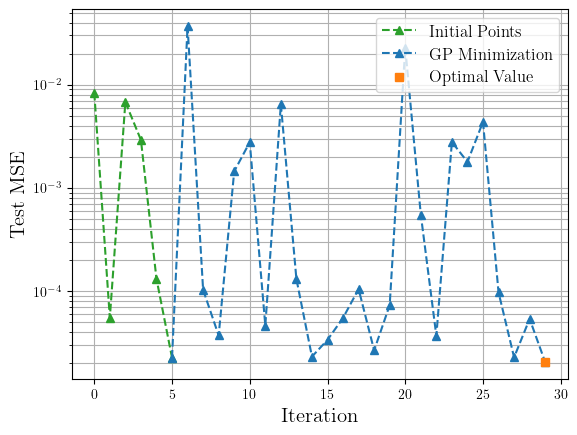

In [36]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/test_mse.pdf', bbox_inches='tight', dpi=300)
plt.show()

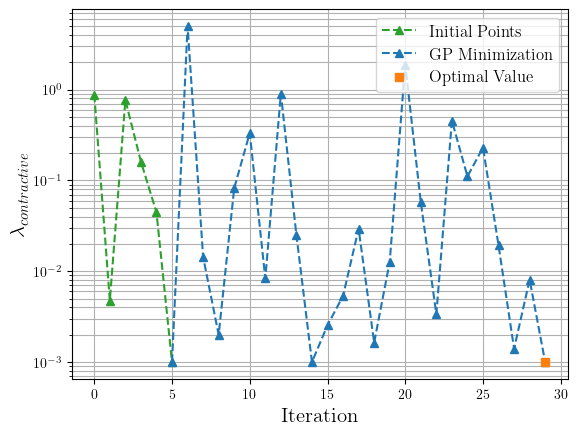

In [37]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        x_iters[:, 0][0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    x_iters[:, 0][a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [x_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('$\lambda_{contractive}$', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/contractive_lmda.pdf', bbox_inches='tight', dpi=300)
plt.show()

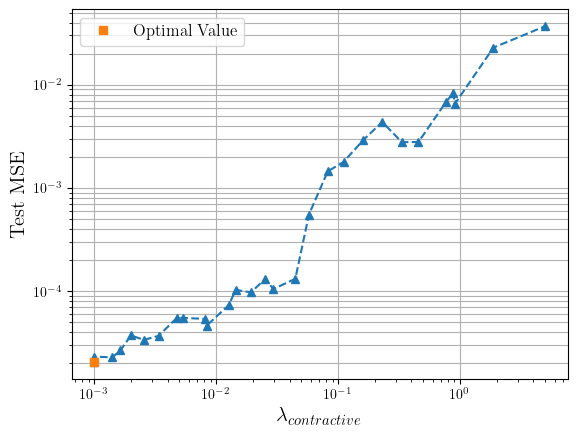

In [38]:
a = 0#n_initial_points
sorted_idx = np.argsort(x_iters[a:, 0])
# sorted_idx = np.arange(x_iters.shape[0]-a)

plt.loglog(
    x_iters[a:, 0][sorted_idx],
    func_iters[a:][sorted_idx],
    label='__nolegend__',
    marker='^',
    linestyle='--',
)
plt.loglog(x_iters[optim_idx, 0], [func_iters[optim_idx]], 's', label='Optimal Value')
plt.xlabel('$\lambda_{contractive}$', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/test_mse_vs_contractive_lmda.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [39]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_ae_nsb+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_ae_nsb+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

In [40]:
# convergence plot
convergence_test_mse = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_test_mse[i] = min_val

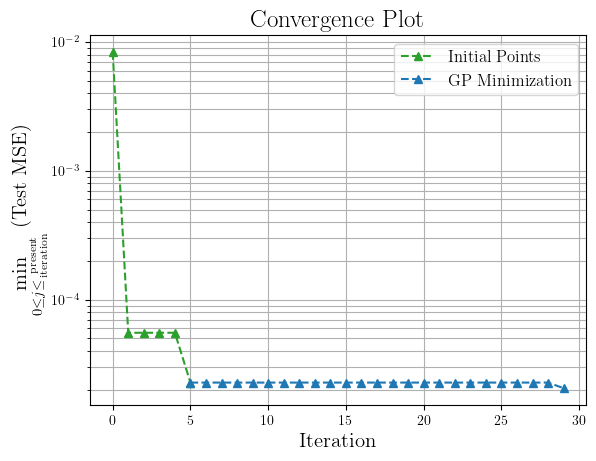

In [41]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        convergence_test_mse[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    convergence_test_mse[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

# KE and Dissipation